# Análisis de Correlación y Regresión: Peso Corporal vs Peso de Filete en Trucha
## Evaluación de Rendimiento de Fileteado en Planta de Proceso

**Autor:** Jorge Carrasco  
**Empresa:** Blumar S.A.  
**Fecha:** 2026-01-21  

---

## Contexto del Estudio

Este análisis evalúa la relación entre el peso corporal completo y el peso del filete en trucha arcoíris (*Oncorhynchus mykiss*) procesada en planta industrial. El objetivo es:

1. **Modelar la relación** entre peso corporal y rendimiento de filete
2. **Predecir el peso de filete** a partir del peso vivo
3. **Optimizar la clasificación** de peces para maximizar rendimiento económico
4. **Evaluar eficiencia** del proceso de fileteado

### Importancia Comercial
- El filete representa el 50-60% del valor comercial del pescado
- Modelos predictivos permiten optimizar logística y clasificación
- Identificación de factores que afectan el rendimiento de filete

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, shapiro, normaltest, jarque_bera
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, linear_harvey_collier
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Importación y Preparación de Datos

In [2]:
# Cargar datos
trucha = pd.read_excel('trucha.xlsx')

# Inspección inicial
print("=== ESTRUCTURA DEL DATASET ===")
print(trucha.info())
print("\n=== PRIMERAS OBSERVACIONES ===")
print(trucha.head(10))
print("\n=== ÚLTIMAS OBSERVACIONES ===")
print(trucha.tail(10))

# Verificar valores faltantes
print("\n=== VALORES FALTANTES ===")
print(trucha.isnull().sum())

# Verificar duplicados
print(f"\n=== REGISTROS DUPLICADOS: {trucha.duplicated().sum()} ===")

=== ESTRUCTURA DEL DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  1000 non-null   float64
 1   fillet  1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB
None

=== PRIMERAS OBSERVACIONES ===
   weight  fillet
0  3261.2  1733.7
1  3435.9  2026.2
2  4285.7  2352.3
3  4196.7  2218.2
4  3786.4  2172.6
5  3876.3  2029.4
6  4630.5  2574.5
7  3415.5  1894.5
8  4155.6  2464.3
9  3668.6  2097.0

=== ÚLTIMAS OBSERVACIONES ===
     weight  fillet
990  4052.6  2495.8
991  5420.4  3194.1
992  3796.1  2118.1
993  4345.0  2288.6
994  3853.2  2026.5
995  3735.7  2141.6
996  4397.4  2505.0
997  3611.3  2181.4
998  3973.8  2295.9
999  4009.1  2014.1

=== VALORES FALTANTES ===
weight    0
fillet    0
dtype: int64

=== REGISTROS DUPLICADOS: 0 ===


## 2. Análisis Exploratorio de Datos (EDA)

### 2.1 Estadísticas Descriptivas

In [3]:
# Estadísticas descriptivas detalladas
estadisticas = trucha[['weight', 'fillet']].describe().T
estadisticas['CV_%'] = (estadisticas['std'] / estadisticas['mean']) * 100
estadisticas['Rango'] = estadisticas['max'] - estadisticas['min']

print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(estadisticas.round(3))

# Calcular porcentaje de filete
trucha['porcentaje_filete'] = (trucha['fillet'] / trucha['weight']) * 100

print("\n=== RENDIMIENTO DE FILETE ===")
print(f"Rendimiento promedio: {trucha['porcentaje_filete'].mean():.2f}% ± {trucha['porcentaje_filete'].std():.2f}%")
print(f"Rango de rendimiento: {trucha['porcentaje_filete'].min():.2f}% - {trucha['porcentaje_filete'].max():.2f}%")
print(f"Mediana de rendimiento: {trucha['porcentaje_filete'].median():.2f}%")

# Categorización por tamaño de peso
trucha['categoria_peso'] = pd.cut(trucha['weight'], 
                                   bins=[0, 3000, 4000, 5000, 10000],
                                   labels=['Pequeño (<3kg)', 'Mediano (3-4kg)', 'Grande (4-5kg)', 'Extra (>5kg)'])

print("\n=== DISTRIBUCIÓN POR CATEGORÍA DE PESO ===")
print(trucha.groupby('categoria_peso', observed=True).agg({
    'weight': ['count', 'mean'],
    'fillet': 'mean',
    'porcentaje_filete': 'mean'
}).round(2))


=== ESTADÍSTICAS DESCRIPTIVAS ===
         count      mean      std     min     25%      50%      75%     max  \
weight  1000.0  3834.123  643.430  2000.0  3394.9  3830.65  4243.95  5801.3   
fillet  1000.0  2130.671  378.333  1046.9  1882.5  2126.40  2358.10  3323.6   

          CV_%   Rango  
weight  16.782  3801.3  
fillet  17.756  2276.7  

=== RENDIMIENTO DE FILETE ===
Rendimiento promedio: 55.59% ± 3.44%
Rango de rendimiento: 45.00% - 65.00%
Mediana de rendimiento: 55.52%

=== DISTRIBUCIÓN POR CATEGORÍA DE PESO ===
                weight            fillet porcentaje_filete
                 count     mean     mean              mean
categoria_peso                                            
Pequeño (<3kg)     100  2721.34  1522.32             55.92
Mediano (3-4kg)    507  3564.75  1984.28             55.66
Grande (4-5kg)     354  4380.20  2426.11             55.38
Extra (>5kg)        39  5232.51  2911.94             55.65


**Interpretación:**
- El rendimiento de filete típico en trucha arcoíris es 50-60% del peso corporal
- La variabilidad en porcentaje de filete puede indicar diferencias en condición corporal
- Peces más grandes pueden tener mejor rendimiento por mayor proporción de músculo

### 2.2 Visualización de Relación entre Variables

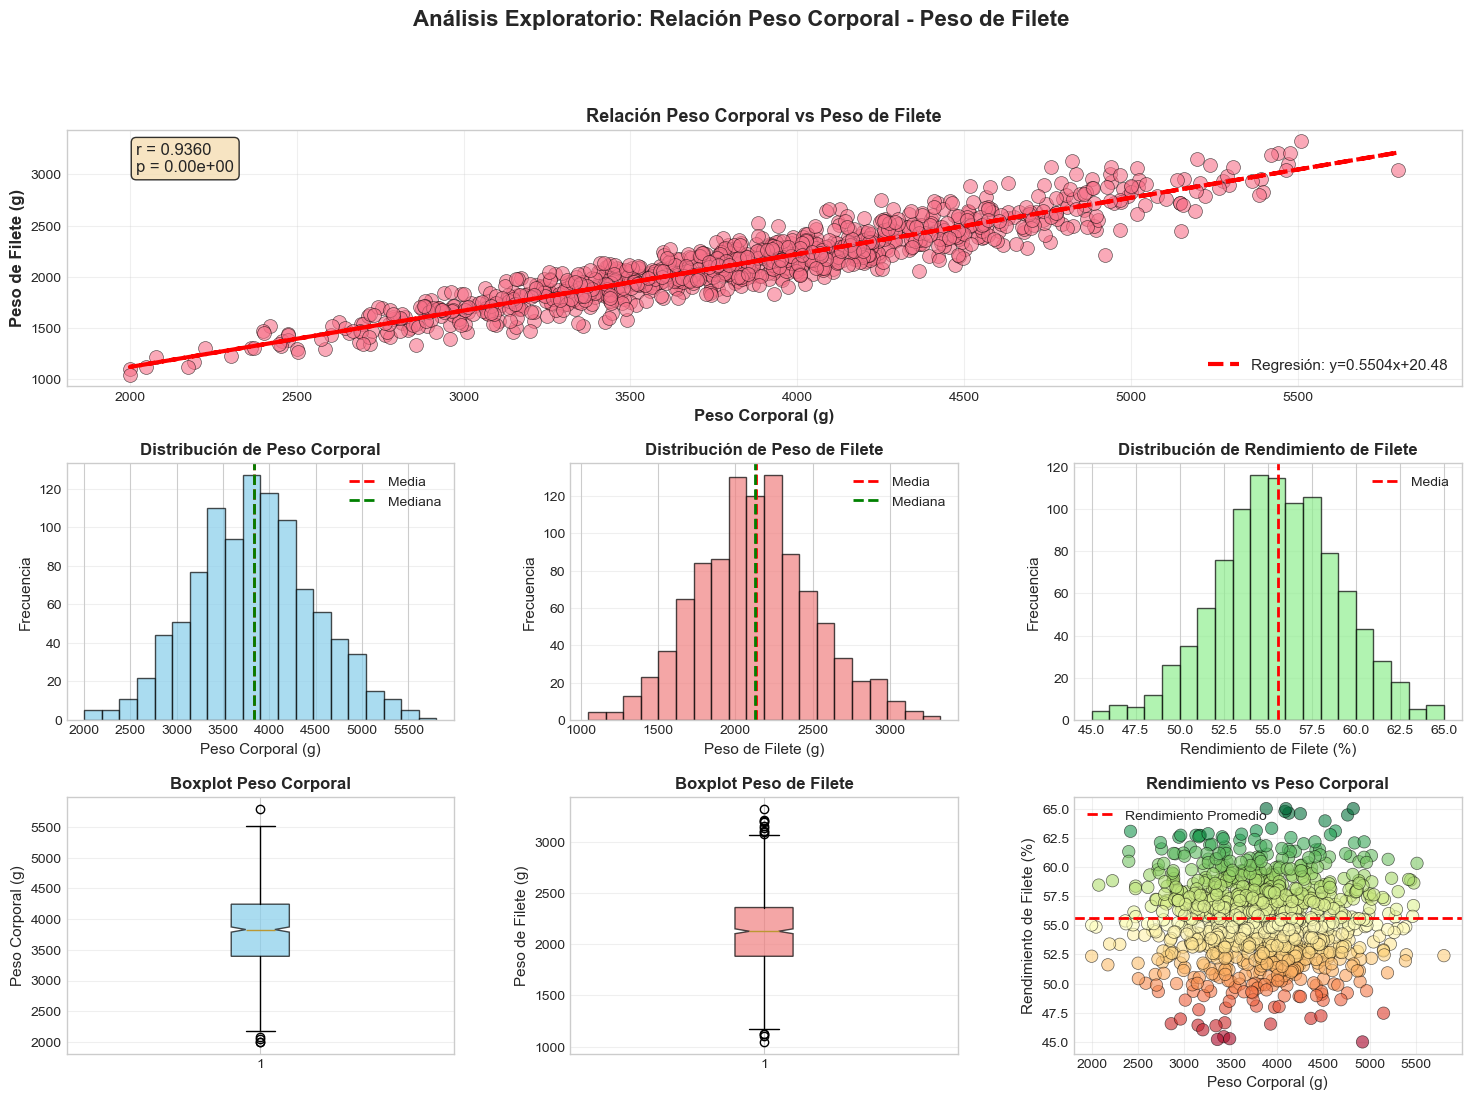


=== INTERPRETACIÓN DE GRÁFICOS EXPLORATORIOS ===

1. Scatter Plot Principal:
   - Correlación de Pearson r=0.9360 indica relación muy fuerte.
   - La línea roja muestra la tendencia lineal ajustada.
   - Dispersión alrededor de la línea indica variabilidad en el rendimiento.

2-3. Histogramas de Peso:
   - Evalúan normalidad y simetría de las distribuciones.
   - Media y mediana cercanas sugieren distribución simétrica.

4. Rendimiento de Filete:
   - Muestra la distribución del porcentaje de aprovechamiento.
   - Variabilidad puede deberse a: condición corporal, técnica de fileteado, categoría de peso.

5-6. Boxplots:
   - Identifican valores atípicos (outliers) que pueden afectar el modelo.
   - Los 'notches' representan intervalos de confianza de la mediana.

7. Rendimiento vs Peso:
   - Evalúa si el rendimiento porcentual cambia con el tamaño del pez.
   - Colores indican nivel de rendimiento (verde=alto, rojo=bajo).


In [4]:
# Panel de visualizaciones exploratorias
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Análisis Exploratorio: Relación Peso Corporal - Peso de Filete', fontsize=16, fontweight='bold')

# 1. Scatter plot principal con línea de regresión
ax1 = fig.add_subplot(gs[0, :])
ax1.scatter(trucha['weight'], trucha['fillet'], alpha=0.6, s=100, edgecolors='black', linewidths=0.5)
z = np.polyfit(trucha['weight'], trucha['fillet'], 1)
p = np.poly1d(z)
ax1.plot(trucha['weight'], p(trucha['weight']), "r--", linewidth=3, label=f'Regresión: y={z[0]:.4f}x+{z[1]:.2f}')
ax1.set_xlabel('Peso Corporal (g)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Peso de Filete (g)', fontsize=12, fontweight='bold')
ax1.set_title('Relación Peso Corporal vs Peso de Filete', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Calcular y mostrar correlación
r_pearson, p_pearson = pearsonr(trucha['weight'], trucha['fillet'])
ax1.text(0.05, 0.95, f'r = {r_pearson:.4f}\np = {p_pearson:.2e}', 
         transform=ax1.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Histograma peso corporal
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(trucha['weight'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax2.axvline(trucha['weight'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
ax2.axvline(trucha['weight'].median(), color='green', linestyle='--', linewidth=2, label='Mediana')
ax2.set_xlabel('Peso Corporal (g)', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Distribución de Peso Corporal', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Histograma peso filete
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(trucha['fillet'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
ax3.axvline(trucha['fillet'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
ax3.axvline(trucha['fillet'].median(), color='green', linestyle='--', linewidth=2, label='Mediana')
ax3.set_xlabel('Peso de Filete (g)', fontsize=11)
ax3.set_ylabel('Frecuencia', fontsize=11)
ax3.set_title('Distribución de Peso de Filete', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Histograma porcentaje de filete
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(trucha['porcentaje_filete'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
ax4.axvline(trucha['porcentaje_filete'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
ax4.set_xlabel('Rendimiento de Filete (%)', fontsize=11)
ax4.set_ylabel('Frecuencia', fontsize=11)
ax4.set_title('Distribución de Rendimiento de Filete', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Boxplot peso corporal
ax5 = fig.add_subplot(gs[2, 0])
bp1 = ax5.boxplot(trucha['weight'], vert=True, patch_artist=True, notch=True)
bp1['boxes'][0].set_facecolor('skyblue')
bp1['boxes'][0].set_alpha(0.7)
ax5.set_ylabel('Peso Corporal (g)', fontsize=11)
ax5.set_title('Boxplot Peso Corporal', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Boxplot peso filete
ax6 = fig.add_subplot(gs[2, 1])
bp2 = ax6.boxplot(trucha['fillet'], vert=True, patch_artist=True, notch=True)
bp2['boxes'][0].set_facecolor('lightcoral')
bp2['boxes'][0].set_alpha(0.7)
ax6.set_ylabel('Peso de Filete (g)', fontsize=11)
ax6.set_title('Boxplot Peso de Filete', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# 7. Scatter porcentaje de filete vs peso
ax7 = fig.add_subplot(gs[2, 2])
ax7.scatter(trucha['weight'], trucha['porcentaje_filete'], alpha=0.6, s=80, 
            c=trucha['porcentaje_filete'], cmap='RdYlGn', edgecolors='black', linewidths=0.5)
ax7.axhline(y=trucha['porcentaje_filete'].mean(), color='red', linestyle='--', linewidth=2, label='Rendimiento Promedio')
ax7.set_xlabel('Peso Corporal (g)', fontsize=11)
ax7.set_ylabel('Rendimiento de Filete (%)', fontsize=11)
ax7.set_title('Rendimiento vs Peso Corporal', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.show()

print("\n=== INTERPRETACIÓN DE GRÁFICOS EXPLORATORIOS ===")
print("\n1. Scatter Plot Principal:")
print(f"   - Correlación de Pearson r={r_pearson:.4f} indica relación {'muy fuerte' if abs(r_pearson) > 0.9 else 'fuerte' if abs(r_pearson) > 0.7 else 'moderada'}.")
print("   - La línea roja muestra la tendencia lineal ajustada.")
print("   - Dispersión alrededor de la línea indica variabilidad en el rendimiento.")
print("\n2-3. Histogramas de Peso:")
print("   - Evalúan normalidad y simetría de las distribuciones.")
print("   - Media y mediana cercanas sugieren distribución simétrica.")
print("\n4. Rendimiento de Filete:")
print("   - Muestra la distribución del porcentaje de aprovechamiento.")
print("   - Variabilidad puede deberse a: condición corporal, técnica de fileteado, categoría de peso.")
print("\n5-6. Boxplots:")
print("   - Identifican valores atípicos (outliers) que pueden afectar el modelo.")
print("   - Los 'notches' representan intervalos de confianza de la mediana.")
print("\n7. Rendimiento vs Peso:")
print("   - Evalúa si el rendimiento porcentual cambia con el tamaño del pez.")
print("   - Colores indican nivel de rendimiento (verde=alto, rojo=bajo).")

## 3. Modelo de Regresión Lineal Simple

### 3.1 Ajuste del Modelo

In [5]:
# Ajustar modelo de regresión lineal
modelo = ols('fillet ~ weight', data=trucha).fit()

print("\n=== RESUMEN DEL MODELO DE REGRESIÓN ===")
print(modelo.summary())

# Extraer parámetros clave
intercepto = modelo.params['Intercept']
pendiente = modelo.params['weight']
r_cuadrado = modelo.rsquared
r_cuadrado_adj = modelo.rsquared_adj
p_modelo = modelo.f_pvalue

print("\n=== ECUACIÓN DEL MODELO ===")
print(f"\nFilete (g) = {intercepto:.4f} + {pendiente:.6f} × Peso (g)")
print(f"\nR² = {r_cuadrado:.4f} ({r_cuadrado*100:.2f}% de varianza explicada)")
print(f"R² ajustado = {r_cuadrado_adj:.4f}")
print(f"p-valor del modelo = {p_modelo:.2e}")

print("\n=== INTERPRETACIÓN DE PARÁMETROS ===")
print(f"\n• Intercepto ({intercepto:.4f}):")
print(f"  Peso de filete estimado cuando peso corporal = 0 (sin interpretación práctica).")
print(f"\n• Pendiente ({pendiente:.6f}):")
print(f"  Por cada gramo adicional de peso corporal, el filete aumenta {pendiente:.6f} g.")
print(f"  Equivalente a: por cada 100g de peso, el filete aumenta {pendiente*100:.4f} g.")
print(f"  Rendimiento implícito: {pendiente*100:.2f}%")

print("\n• R² (Coeficiente de Determinación):")
print(f"  El {r_cuadrado*100:.2f}% de la variabilidad en peso de filete es explicada")
print(f"  por el peso corporal. {'Excelente ajuste' if r_cuadrado > 0.9 else 'Buen ajuste' if r_cuadrado > 0.7 else 'Ajuste moderado'}.")

# Predicciones del modelo
trucha['fillet_pred'] = modelo.fittedvalues
trucha['residuales'] = modelo.resid

# Ejemplos de predicción
print("\n=== EJEMPLOS DE PREDICCIÓN ===")
pesos_ejemplo = [3000, 3500, 4000, 4500, 5000]
for peso in pesos_ejemplo:
    filete_pred = intercepto + pendiente * peso
    rendimiento_pred = (filete_pred / peso) * 100
    print(f"Peso: {peso}g → Filete predicho: {filete_pred:.1f}g (Rendimiento: {rendimiento_pred:.2f}%)")


=== RESUMEN DEL MODELO DE REGRESIÓN ===
                            OLS Regression Results                            
Dep. Variable:                 fillet   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     7058.
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:05:49   Log-Likelihood:                -6310.0
No. Observations:                1000   AIC:                         1.262e+04
Df Residuals:                     998   BIC:                         1.263e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

## 4. Evaluación de Supuestos del Modelo de Regresión

### 4.1 Supuesto de Linealidad

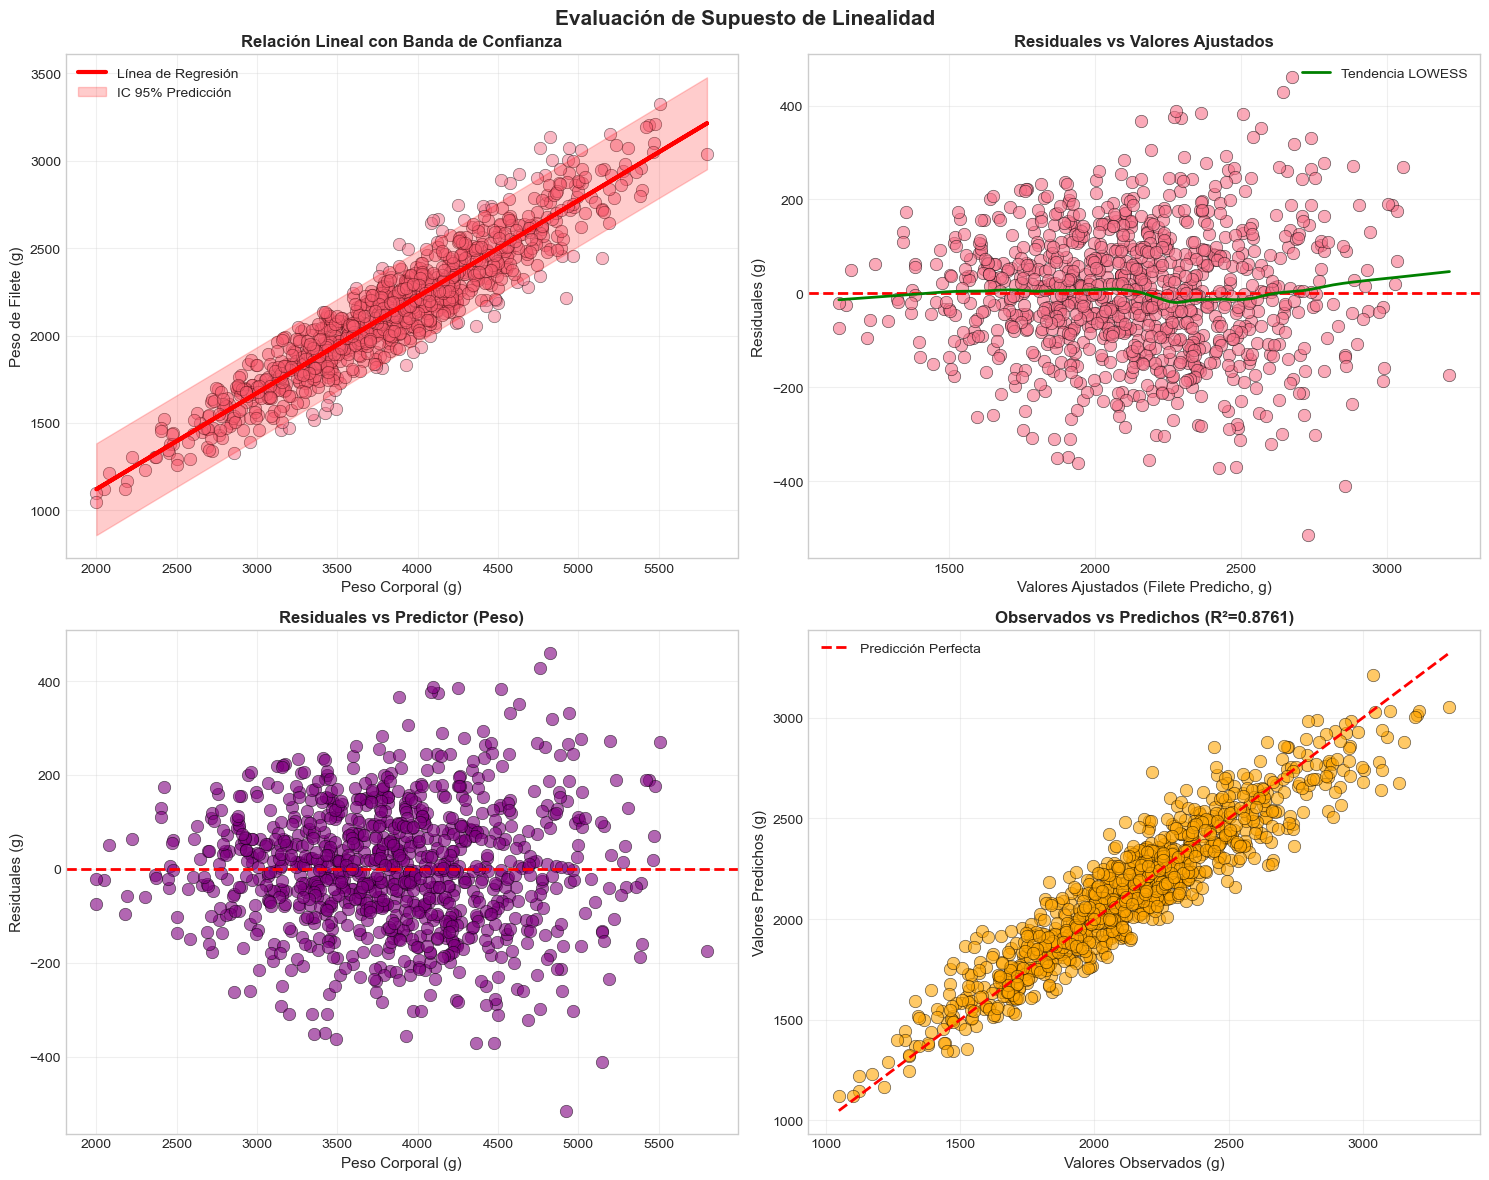


=== TEST DE HARVEY-COLLIER (Linealidad) ===
Estadístico t: -0.5387
Valor p: 0.590218

✓ No se rechaza H₀: La relación es lineal.

=== INTERPRETACIÓN DE GRÁFICOS DE LINEALIDAD ===

1. Scatter con Banda de Confianza:
   - Los datos deben distribuirse aleatoriamente alrededor de la línea de regresión.
   - El 95% de observaciones futuras caerán dentro de la banda roja.

2. Residuales vs Ajustados:
   - Debe mostrar patrón aleatorio sin estructura (no forma de U, V o embudo).
   - Línea LOWESS (verde) debe ser aproximadamente horizontal sobre cero.
   - Patrones sistemáticos indican no linealidad o heterocedasticidad.

3. Residuales vs Predictor:
   - Similar al anterior, detecta dependencia no lineal del predictor.

4. Observados vs Predichos:
   - Los puntos deben estar cerca de la línea diagonal.
   - Desviaciones sistemáticas indican sesgo en el modelo.


In [6]:
# Test de linealidad de Harvey-Collier
try:
    hc_stat, hc_p = linear_harvey_collier(modelo)
    hc_disponible = True
except:
    hc_disponible = False
    print("Test de Harvey-Collier no disponible (requiere > 2 predictores)")

# Gráficos de linealidad
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evaluación de Supuesto de Linealidad', fontsize=15, fontweight='bold')

# 1. Scatter con línea de regresión y banda de confianza
axes[0, 0].scatter(trucha['weight'], trucha['fillet'], alpha=0.5, s=80, edgecolors='black', linewidths=0.5)
axes[0, 0].plot(trucha['weight'], trucha['fillet_pred'], 'r-', linewidth=3, label='Línea de Regresión')

# Intervalos de confianza
predictions = modelo.get_prediction(trucha[['weight']])
prediction_summary = predictions.summary_frame(alpha=0.05)
axes[0, 0].fill_between(trucha['weight'].sort_values(), 
                         prediction_summary.loc[trucha['weight'].sort_values().index, 'obs_ci_lower'],
                         prediction_summary.loc[trucha['weight'].sort_values().index, 'obs_ci_upper'],
                         alpha=0.2, color='red', label='IC 95% Predicción')

axes[0, 0].set_xlabel('Peso Corporal (g)', fontsize=11)
axes[0, 0].set_ylabel('Peso de Filete (g)', fontsize=11)
axes[0, 0].set_title('Relación Lineal con Banda de Confianza', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuales vs valores ajustados
axes[0, 1].scatter(trucha['fillet_pred'], trucha['residuales'], alpha=0.6, s=80, edgecolors='black', linewidths=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Valores Ajustados (Filete Predicho, g)', fontsize=11)
axes[0, 1].set_ylabel('Residuales (g)', fontsize=11)
axes[0, 1].set_title('Residuales vs Valores Ajustados', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Añadir línea LOWESS para detectar no linealidad
from statsmodels.nonparametric.smoothers_lowess import lowess
lowess_result = lowess(trucha['residuales'], trucha['fillet_pred'], frac=0.3)
axes[0, 1].plot(lowess_result[:, 0], lowess_result[:, 1], 'g-', linewidth=2, label='Tendencia LOWESS')
axes[0, 1].legend()

# 3. Residuales vs predictor (weight)
axes[1, 0].scatter(trucha['weight'], trucha['residuales'], alpha=0.6, s=80, color='purple', edgecolors='black', linewidths=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Peso Corporal (g)', fontsize=11)
axes[1, 0].set_ylabel('Residuales (g)', fontsize=11)
axes[1, 0].set_title('Residuales vs Predictor (Peso)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Gráfico de valores observados vs predichos
axes[1, 1].scatter(trucha['fillet'], trucha['fillet_pred'], alpha=0.6, s=80, color='orange', edgecolors='black', linewidths=0.5)
# Línea de identidad perfecta
min_val = min(trucha['fillet'].min(), trucha['fillet_pred'].min())
max_val = max(trucha['fillet'].max(), trucha['fillet_pred'].max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
axes[1, 1].set_xlabel('Valores Observados (g)', fontsize=11)
axes[1, 1].set_ylabel('Valores Predichos (g)', fontsize=11)
axes[1, 1].set_title(f'Observados vs Predichos (R²={r_cuadrado:.4f})', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if hc_disponible:
    print("\n=== TEST DE HARVEY-COLLIER (Linealidad) ===")
    print(f"Estadístico t: {hc_stat:.4f}")
    print(f"Valor p: {hc_p:.6f}")
    if hc_p > 0.05:
        print("\n✓ No se rechaza H₀: La relación es lineal.")
    else:
        print("\n✗ Se rechaza H₀: Evidencia de no linealidad.")

print("\n=== INTERPRETACIÓN DE GRÁFICOS DE LINEALIDAD ===")
print("\n1. Scatter con Banda de Confianza:")
print("   - Los datos deben distribuirse aleatoriamente alrededor de la línea de regresión.")
print("   - El 95% de observaciones futuras caerán dentro de la banda roja.")
print("\n2. Residuales vs Ajustados:")
print("   - Debe mostrar patrón aleatorio sin estructura (no forma de U, V o embudo).")
print("   - Línea LOWESS (verde) debe ser aproximadamente horizontal sobre cero.")
print("   - Patrones sistemáticos indican no linealidad o heterocedasticidad.")
print("\n3. Residuales vs Predictor:")
print("   - Similar al anterior, detecta dependencia no lineal del predictor.")
print("\n4. Observados vs Predichos:")
print("   - Los puntos deben estar cerca de la línea diagonal.")
print("   - Desviaciones sistemáticas indican sesgo en el modelo.")

### 4.2 Supuesto de Independencia

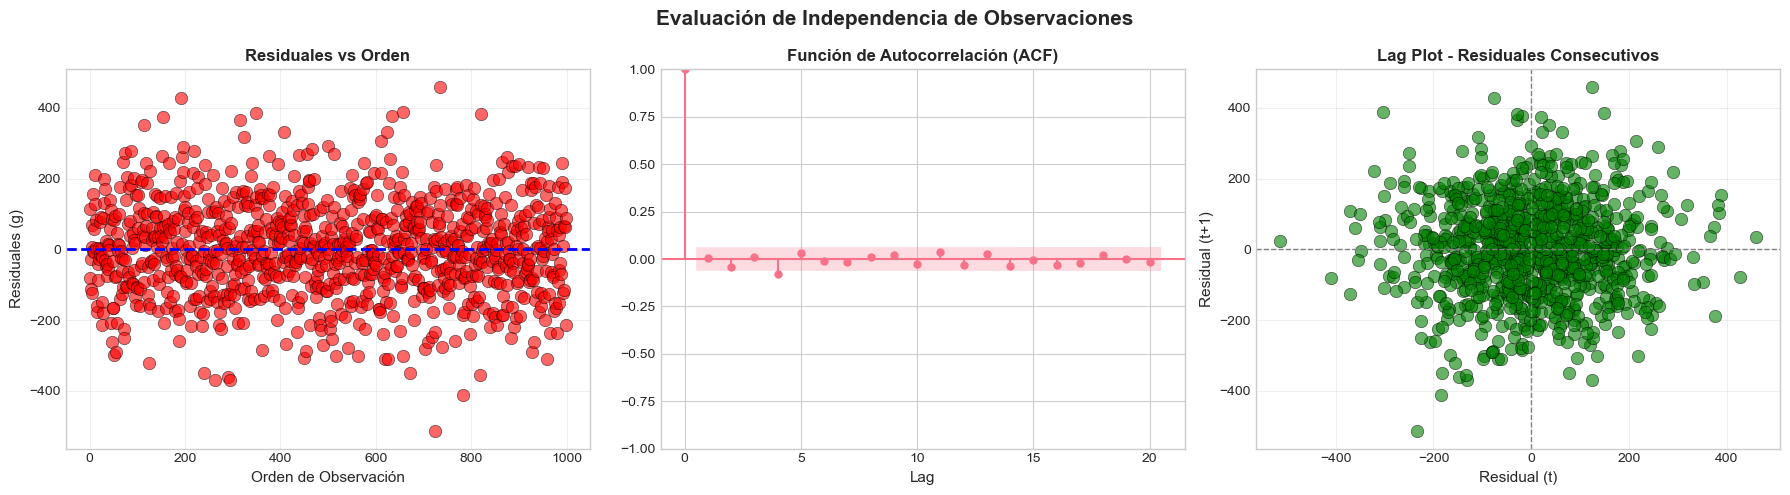


=== TEST DE DURBIN-WATSON ===
Estadístico DW: 1.9874

Interpretación:
  DW ≈ 2: No autocorrelación (independencia)
  DW < 2: Autocorrelación positiva
  DW > 2: Autocorrelación negativa
  Rango aceptable: 1.5 - 2.5

✓ CONCLUSIÓN: DW=1.9874 está en rango aceptable.
  Se asume independencia de las observaciones.

=== TEST DE LJUNG-BOX ===
      lb_stat  lb_pvalue
10  10.602894   0.389281

✓ No se rechaza H₀: No hay autocorrelación significativa.

=== INTERPRETACIÓN ===

• Residuales vs Orden: No debe mostrar tendencias o patrones cíclicos.
  En datos de planta, el orden puede relacionarse con lotes de procesamiento.

• ACF: Los lags no deben exceder las bandas de confianza azules.
  Autocorrelación puede indicar: lotes procesados juntos, condiciones variables.

• Lag Plot: Debe mostrar dispersión aleatoria sin patrón lineal.
  Patrón lineal positivo indica autocorrelación positiva.


In [7]:
# Test de Durbin-Watson
dw_stat = durbin_watson(trucha['residuales'])

# Test de Ljung-Box para autocorrelación
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(trucha['residuales'], lags=[10], return_df=True)

# Gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Evaluación de Independencia de Observaciones', fontsize=15, fontweight='bold')

# 1. Residuales vs orden
axes[0].scatter(range(len(trucha)), trucha['residuales'], alpha=0.6, s=80, color='red', edgecolors='black', linewidths=0.5)
axes[0].axhline(y=0, color='blue', linestyle='--', linewidth=2)
axes[0].set_xlabel('Orden de Observación', fontsize=11)
axes[0].set_ylabel('Residuales (g)', fontsize=11)
axes[0].set_title('Residuales vs Orden', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Función de autocorrelación (ACF)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(trucha['residuales'], ax=axes[1], lags=20, alpha=0.05)
axes[1].set_title('Función de Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)

# 3. Gráfico de residuales consecutivos
axes[2].scatter(trucha['residuales'][:-1].values, trucha['residuales'][1:].values, 
                alpha=0.6, s=80, color='green', edgecolors='black', linewidths=0.5)
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[2].axvline(x=0, color='gray', linestyle='--', linewidth=1)
axes[2].set_xlabel('Residual (t)', fontsize=11)
axes[2].set_ylabel('Residual (t+1)', fontsize=11)
axes[2].set_title('Lag Plot - Residuales Consecutivos', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== TEST DE DURBIN-WATSON ===")
print(f"Estadístico DW: {dw_stat:.4f}")
print("\nInterpretación:")
print("  DW ≈ 2: No autocorrelación (independencia)")
print("  DW < 2: Autocorrelación positiva")
print("  DW > 2: Autocorrelación negativa")
print("  Rango aceptable: 1.5 - 2.5")

if 1.5 <= dw_stat <= 2.5:
    print(f"\n✓ CONCLUSIÓN: DW={dw_stat:.4f} está en rango aceptable.")
    print("  Se asume independencia de las observaciones.")
else:
    print(f"\n⚠ ADVERTENCIA: DW={dw_stat:.4f} sugiere posible autocorrelación.")

print("\n=== TEST DE LJUNG-BOX ===")
print(lb_test)
if lb_test['lb_pvalue'].values[0] > 0.05:
    print("\n✓ No se rechaza H₀: No hay autocorrelación significativa.")
else:
    print("\n✗ Se rechaza H₀: Existe autocorrelación significativa.")

print("\n=== INTERPRETACIÓN ===")
print("\n• Residuales vs Orden: No debe mostrar tendencias o patrones cíclicos.")
print("  En datos de planta, el orden puede relacionarse con lotes de procesamiento.")
print("\n• ACF: Los lags no deben exceder las bandas de confianza azules.")
print("  Autocorrelación puede indicar: lotes procesados juntos, condiciones variables.")
print("\n• Lag Plot: Debe mostrar dispersión aleatoria sin patrón lineal.")
print("  Patrón lineal positivo indica autocorrelación positiva.")

### 4.3 Supuesto de Homocedasticidad (Varianza Constante)

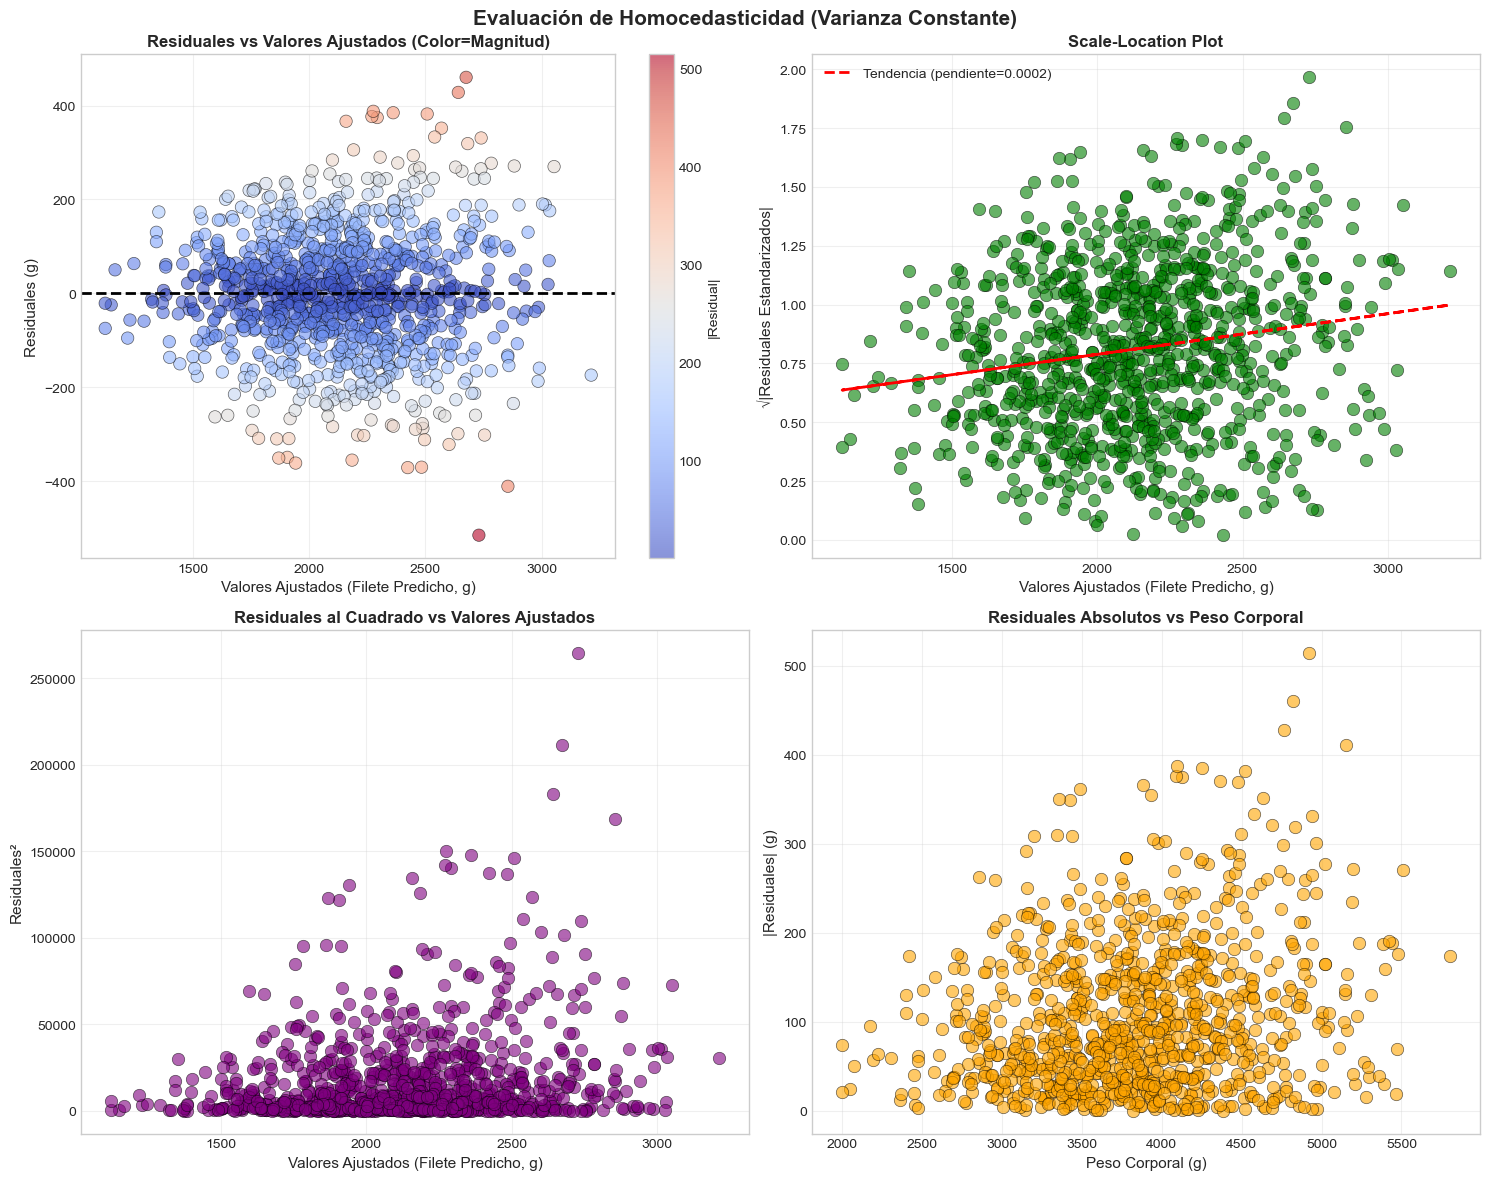


=== TEST DE BREUSCH-PAGAN ===
Estadístico LM: 40.3880
Valor p (LM): 0.000000
Estadístico F: 42.0037
Valor p (F): 0.000000

✗ Se rechaza H₀: Heterocedasticidad detectada (varianza no constante).
  Considerar: transformación de variables, regresión ponderada, errores robustos.

=== TEST DE WHITE ===
Estadístico LM: 40.8067
Valor p (LM): 0.000000

✗ Se rechaza H₀: Heterocedasticidad detectada.

=== INTERPRETACIÓN DE GRÁFICOS ===

1. Residuales vs Ajustados: La dispersión vertical debe ser constante.
   Patrón de embudo (▷ o ◁) indica heterocedasticidad.

2. Scale-Location: La línea de tendencia debe ser aproximadamente horizontal.
   Pendiente actual: 0.0002 (aceptable)

3. Residuales²: No debe mostrar tendencia creciente/decreciente.
   Útil para detectar dependencia de la varianza con los valores ajustados.

4. |Residuales| vs Predictor: Similar interpretación, detecta heterocedasticidad.


In [8]:
# Test de Breusch-Pagan
bp_test = het_breuschpagan(trucha['residuales'], modelo.model.exog)
bp_lm, bp_lm_p, bp_f, bp_f_p = bp_test

# Test de White
from statsmodels.stats.diagnostic import het_white
white_test = het_white(trucha['residuales'], modelo.model.exog)
white_lm, white_lm_p, white_f, white_f_p = white_test

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evaluación de Homocedasticidad (Varianza Constante)', fontsize=15, fontweight='bold')

# 1. Residuales vs valores ajustados
axes[0, 0].scatter(trucha['fillet_pred'], trucha['residuales'], alpha=0.6, s=80, 
                   c=np.abs(trucha['residuales']), cmap='coolwarm', edgecolors='black', linewidths=0.5)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Valores Ajustados (Filete Predicho, g)', fontsize=11)
axes[0, 0].set_ylabel('Residuales (g)', fontsize=11)
axes[0, 0].set_title('Residuales vs Valores Ajustados (Color=Magnitud)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0], label='|Residual|')

# 2. Scale-Location plot
residuales_std = np.sqrt(np.abs((trucha['residuales'] - trucha['residuales'].mean()) / trucha['residuales'].std()))
axes[0, 1].scatter(trucha['fillet_pred'], residuales_std, alpha=0.6, s=80, color='green', edgecolors='black', linewidths=0.5)
z = np.polyfit(trucha['fillet_pred'], residuales_std, 1)
p = np.poly1d(z)
axes[0, 1].plot(trucha['fillet_pred'], p(trucha['fillet_pred']), "r--", linewidth=2, label=f'Tendencia (pendiente={z[0]:.4f})')
axes[0, 1].set_xlabel('Valores Ajustados (Filete Predicho, g)', fontsize=11)
axes[0, 1].set_ylabel('√|Residuales Estandarizados|', fontsize=11)
axes[0, 1].set_title('Scale-Location Plot', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuales al cuadrado vs valores ajustados
axes[1, 0].scatter(trucha['fillet_pred'], trucha['residuales']**2, alpha=0.6, s=80, color='purple', edgecolors='black', linewidths=0.5)
axes[1, 0].set_xlabel('Valores Ajustados (Filete Predicho, g)', fontsize=11)
axes[1, 0].set_ylabel('Residuales²', fontsize=11)
axes[1, 0].set_title('Residuales al Cuadrado vs Valores Ajustados', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuales absolutos vs predictor
axes[1, 1].scatter(trucha['weight'], np.abs(trucha['residuales']), alpha=0.6, s=80, color='orange', edgecolors='black', linewidths=0.5)
axes[1, 1].set_xlabel('Peso Corporal (g)', fontsize=11)
axes[1, 1].set_ylabel('|Residuales| (g)', fontsize=11)
axes[1, 1].set_title('Residuales Absolutos vs Peso Corporal', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== TEST DE BREUSCH-PAGAN ===")
print(f"Estadístico LM: {bp_lm:.4f}")
print(f"Valor p (LM): {bp_lm_p:.6f}")
print(f"Estadístico F: {bp_f:.4f}")
print(f"Valor p (F): {bp_f_p:.6f}")

if bp_lm_p > 0.05:
    print("\n✓ No se rechaza H₀: Homocedasticidad presente (varianza constante).")
else:
    print("\n✗ Se rechaza H₀: Heterocedasticidad detectada (varianza no constante).")
    print("  Considerar: transformación de variables, regresión ponderada, errores robustos.")

print("\n=== TEST DE WHITE ===")
print(f"Estadístico LM: {white_lm:.4f}")
print(f"Valor p (LM): {white_lm_p:.6f}")

if white_lm_p > 0.05:
    print("\n✓ No se rechaza H₀: Homocedasticidad presente.")
else:
    print("\n✗ Se rechaza H₀: Heterocedasticidad detectada.")

print("\n=== INTERPRETACIÓN DE GRÁFICOS ===")
print("\n1. Residuales vs Ajustados: La dispersión vertical debe ser constante.")
print("   Patrón de embudo (▷ o ◁) indica heterocedasticidad.")
print("\n2. Scale-Location: La línea de tendencia debe ser aproximadamente horizontal.")
print(f"   Pendiente actual: {z[0]:.4f} {'(aceptable)' if abs(z[0]) < 0.01 else '(revisar)'}")
print("\n3. Residuales²: No debe mostrar tendencia creciente/decreciente.")
print("   Útil para detectar dependencia de la varianza con los valores ajustados.")
print("\n4. |Residuales| vs Predictor: Similar interpretación, detecta heterocedasticidad.")

### 4.4 Supuesto de Normalidad de Residuales

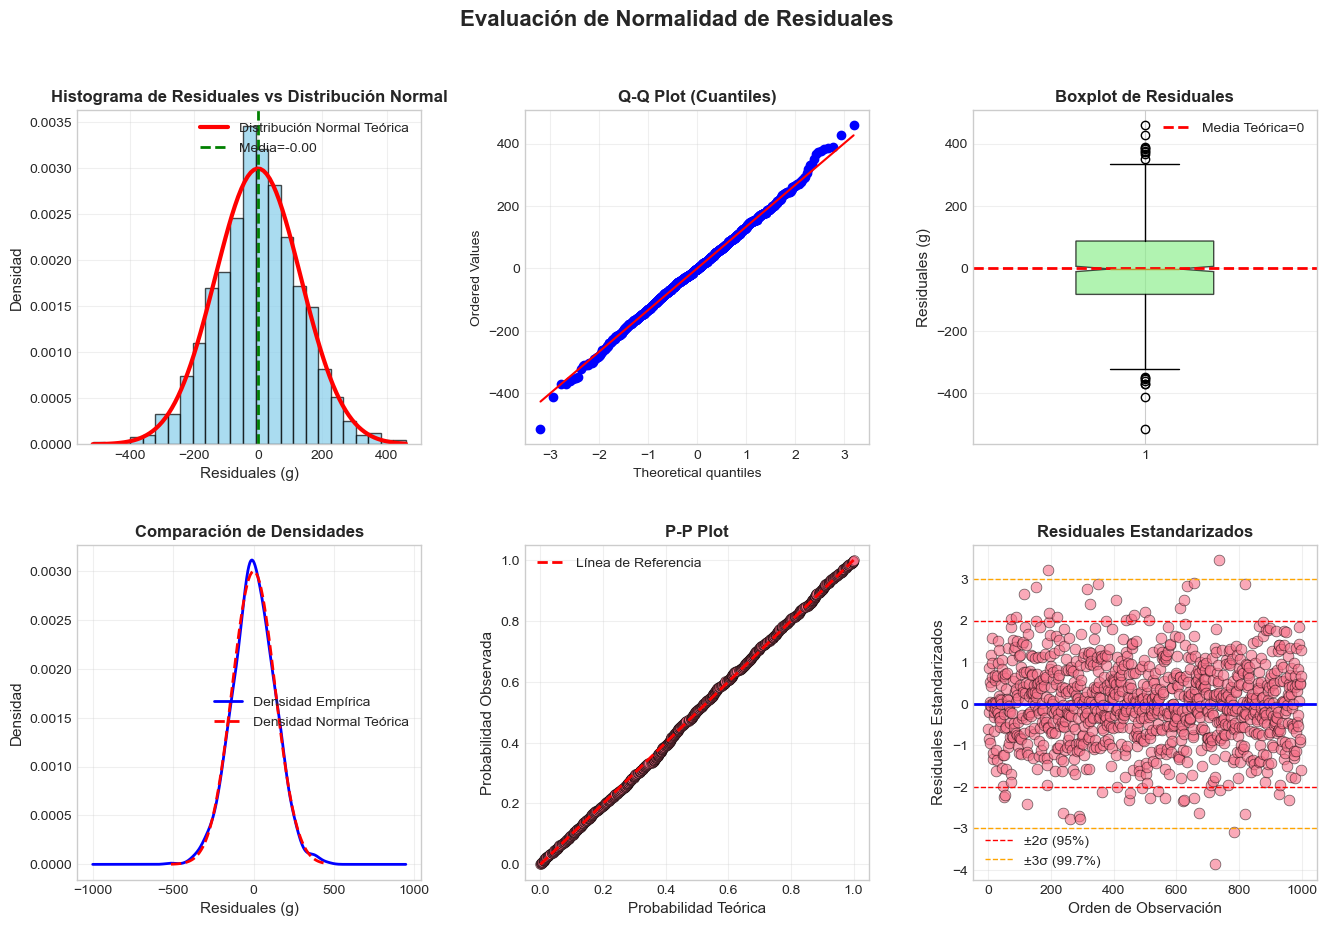


TESTS DE NORMALIDAD DE RESIDUALES

1. Test de Shapiro-Wilk:
   Estadístico W: 0.998312
   Valor p: 0.438130
   ✓ No se rechaza H₀: Residuales siguen distribución normal.

2. Test de Jarque-Bera:
   Estadístico JB: 4.624983
   Valor p: 0.099014
   ✓ No se rechaza H₀: Residuales siguen distribución normal.

3. Test de Kolmogorov-Smirnov:
   Estadístico D: 0.022957
   Valor p: 0.658948
   ✓ No se rechaza H₀: Residuales siguen distribución normal.

4. Test de Anderson-Darling:
   Estadístico: 0.358045
   Valores críticos (α): {np.float64(15.0): np.float64(0.574), np.float64(10.0): np.float64(0.653), np.float64(5.0): np.float64(0.784), np.float64(2.5): np.float64(0.914), np.float64(1.0): np.float64(1.088)}
   ✓ No rechazado al 15.0% de significancia
   ✓ No rechazado al 10.0% de significancia
   ✓ No rechazado al 5.0% de significancia
   ✓ No rechazado al 2.5% de significancia
   ✓ No rechazado al 1.0% de significancia

ESTADÍSTICAS DE FORMA

Asimetría (Skewness): -0.0122
  Interpretación:

In [9]:
# Tests de normalidad
shapiro_stat, shapiro_p = shapiro(trucha['residuales'])
jb_stat, jb_p = jarque_bera(trucha['residuales'])
ks_stat, ks_p = stats.kstest(trucha['residuales'], 'norm', 
                              args=(trucha['residuales'].mean(), trucha['residuales'].std()))
anderson_result = stats.anderson(trucha['residuales'], dist='norm')

# Gráficos
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Evaluación de Normalidad de Residuales', fontsize=16, fontweight='bold')

# 1. Histograma con curva normal
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(trucha['residuales'], bins=25, density=True, alpha=0.7, color='skyblue', edgecolor='black')
mu, sigma = trucha['residuales'].mean(), trucha['residuales'].std()
x = np.linspace(trucha['residuales'].min(), trucha['residuales'].max(), 100)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=3, label='Distribución Normal Teórica')
ax1.axvline(mu, color='green', linestyle='--', linewidth=2, label=f'Media={mu:.2f}')
ax1.set_xlabel('Residuales (g)', fontsize=11)
ax1.set_ylabel('Densidad', fontsize=11)
ax1.set_title('Histograma de Residuales vs Distribución Normal', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Q-Q Plot
ax2 = fig.add_subplot(gs[0, 1])
stats.probplot(trucha['residuales'], dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot (Cuantiles)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Boxplot de residuales
ax3 = fig.add_subplot(gs[0, 2])
bp = ax3.boxplot(trucha['residuales'], vert=True, patch_artist=True, notch=True,
                 widths=0.4, boxprops=dict(facecolor='lightgreen', alpha=0.7))
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Media Teórica=0')
ax3.set_ylabel('Residuales (g)', fontsize=11)
ax3.set_title('Boxplot de Residuales', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Gráfico de densidad con comparación normal
ax4 = fig.add_subplot(gs[1, 0])
trucha['residuales'].plot(kind='density', ax=ax4, color='blue', linewidth=2, label='Densidad Empírica')
ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'r--', linewidth=2, label='Densidad Normal Teórica')
ax4.set_xlabel('Residuales (g)', fontsize=11)
ax4.set_ylabel('Densidad', fontsize=11)
ax4.set_title('Comparación de Densidades', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. P-P Plot
ax5 = fig.add_subplot(gs[1, 1])
# Ordenar residuales y calcular probabilidades
sorted_resid = np.sort(trucha['residuales'])
theoretical_probs = stats.norm.cdf(sorted_resid, loc=mu, scale=sigma)
sample_probs = np.arange(1, len(sorted_resid) + 1) / (len(sorted_resid) + 1)
ax5.scatter(theoretical_probs, sample_probs, alpha=0.6, s=50, edgecolors='black', linewidths=0.5)
ax5.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Línea de Referencia')
ax5.set_xlabel('Probabilidad Teórica', fontsize=11)
ax5.set_ylabel('Probabilidad Observada', fontsize=11)
ax5.set_title('P-P Plot', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Residuales estandarizados
ax6 = fig.add_subplot(gs[1, 2])
residuales_std = (trucha['residuales'] - mu) / sigma
ax6.scatter(range(len(residuales_std)), residuales_std, alpha=0.6, s=60, edgecolors='black', linewidths=0.5)
ax6.axhline(y=0, color='blue', linestyle='-', linewidth=2)
ax6.axhline(y=2, color='red', linestyle='--', linewidth=1, label='±2σ (95%)')
ax6.axhline(y=-2, color='red', linestyle='--', linewidth=1)
ax6.axhline(y=3, color='orange', linestyle='--', linewidth=1, label='±3σ (99.7%)')
ax6.axhline(y=-3, color='orange', linestyle='--', linewidth=1)
ax6.set_xlabel('Orden de Observación', fontsize=11)
ax6.set_ylabel('Residuales Estandarizados', fontsize=11)
ax6.set_title('Residuales Estandarizados', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.show()

# Resultados de tests
print("\n" + "="*70)
print("TESTS DE NORMALIDAD DE RESIDUALES")
print("="*70)

print("\n1. Test de Shapiro-Wilk:")
print(f"   Estadístico W: {shapiro_stat:.6f}")
print(f"   Valor p: {shapiro_p:.6f}")
if shapiro_p > 0.05:
    print("   ✓ No se rechaza H₀: Residuales siguen distribución normal.")
else:
    print("   ✗ Se rechaza H₀: Residuales se desvían de la normalidad.")

print("\n2. Test de Jarque-Bera:")
print(f"   Estadístico JB: {jb_stat:.6f}")
print(f"   Valor p: {jb_p:.6f}")
if jb_p > 0.05:
    print("   ✓ No se rechaza H₀: Residuales siguen distribución normal.")
else:
    print("   ✗ Se rechaza H₀: Residuales se desvían de la normalidad.")

print("\n3. Test de Kolmogorov-Smirnov:")
print(f"   Estadístico D: {ks_stat:.6f}")
print(f"   Valor p: {ks_p:.6f}")
if ks_p > 0.05:
    print("   ✓ No se rechaza H₀: Residuales siguen distribución normal.")
else:
    print("   ✗ Se rechaza H₀: Residuales se desvían de la normalidad.")

print("\n4. Test de Anderson-Darling:")
print(f"   Estadístico: {anderson_result.statistic:.6f}")
print(f"   Valores críticos (α): {dict(zip(anderson_result.significance_level, anderson_result.critical_values))}")
for i, (sig_level, crit_val) in enumerate(zip(anderson_result.significance_level, anderson_result.critical_values)):
    if anderson_result.statistic < crit_val:
        print(f"   ✓ No rechazado al {sig_level}% de significancia")
    else:
        print(f"   ✗ Rechazado al {sig_level}% de significancia")

# Estadísticas de desviación de normalidad
print("\n" + "="*70)
print("ESTADÍSTICAS DE FORMA")
print("="*70)
skewness = stats.skew(trucha['residuales'])
kurtosis = stats.kurtosis(trucha['residuales'])
print(f"\nAsimetría (Skewness): {skewness:.4f}")
print("  Interpretación: 0=simétrico, >0=sesgo derecha, <0=sesgo izquierda")
print(f"  Rango aceptable: -0.5 a 0.5 → {'ACEPTABLE' if abs(skewness) < 0.5 else 'REVISAR'}")

print(f"\nCurtosis (Exceso): {kurtosis:.4f}")
print("  Interpretación: 0=normal, >0=colas pesadas, <0=colas ligeras")
print(f"  Rango aceptable: -1 a 1 → {'ACEPTABLE' if abs(kurtosis) < 1 else 'REVISAR'}")

# Outliers en residuales estandarizados
n_outliers_2sigma = np.sum(np.abs(residuales_std) > 2)
n_outliers_3sigma = np.sum(np.abs(residuales_std) > 3)
print("\n" + "="*70)
print("ANÁLISIS DE OUTLIERS")
print("="*70)
print(f"\nObservaciones fuera de ±2σ: {n_outliers_2sigma} ({n_outliers_2sigma/len(trucha)*100:.1f}%)")
print(f"  Esperado en distribución normal: ~5%")
print(f"\nObservaciones fuera de ±3σ: {n_outliers_3sigma} ({n_outliers_3sigma/len(trucha)*100:.1f}%)")
print(f"  Esperado en distribución normal: ~0.3%")

print("\n" + "="*70)
print("INTERPRETACIÓN DE GRÁFICOS")
print("="*70)
print("\n1. Histograma: Debe aproximarse a la curva normal roja.")
print("\n2. Q-Q Plot: Puntos deben alinearse sobre la diagonal.")
print("   - Desviación en cola inferior: Sesgo negativo o outliers bajos")
print("   - Desviación en cola superior: Sesgo positivo o outliers altos")
print("   - Forma de S: Colas pesadas (leptocúrtica)")
print("\n3. P-P Plot: Similar a Q-Q, evalúa ajuste de probabilidades acumuladas.")
print("\n4. Residuales Estandarizados: ~95% deben estar dentro de ±2σ.")

print("\n" + "="*70)
print("NOTA SOBRE ROBUSTEZ")
print("="*70)
print("La regresión lineal es robusta ante desviaciones moderadas de normalidad cuando:")
print("  • El tamaño de muestra es grande (n > 30)")
print("  • Las desviaciones son leves (principalmente en las colas)")
print("  • Los otros supuestos se cumplen (linealidad, homocedasticidad, independencia)")
print("\nLa normalidad es MÁS CRÍTICA para:")
print("  • Intervalos de confianza y predicción")
print("  • Pruebas de hipótesis sobre los parámetros")
print("  • Muestras pequeñas (n < 30)")

## 5. Análisis de Influencia y Outliers

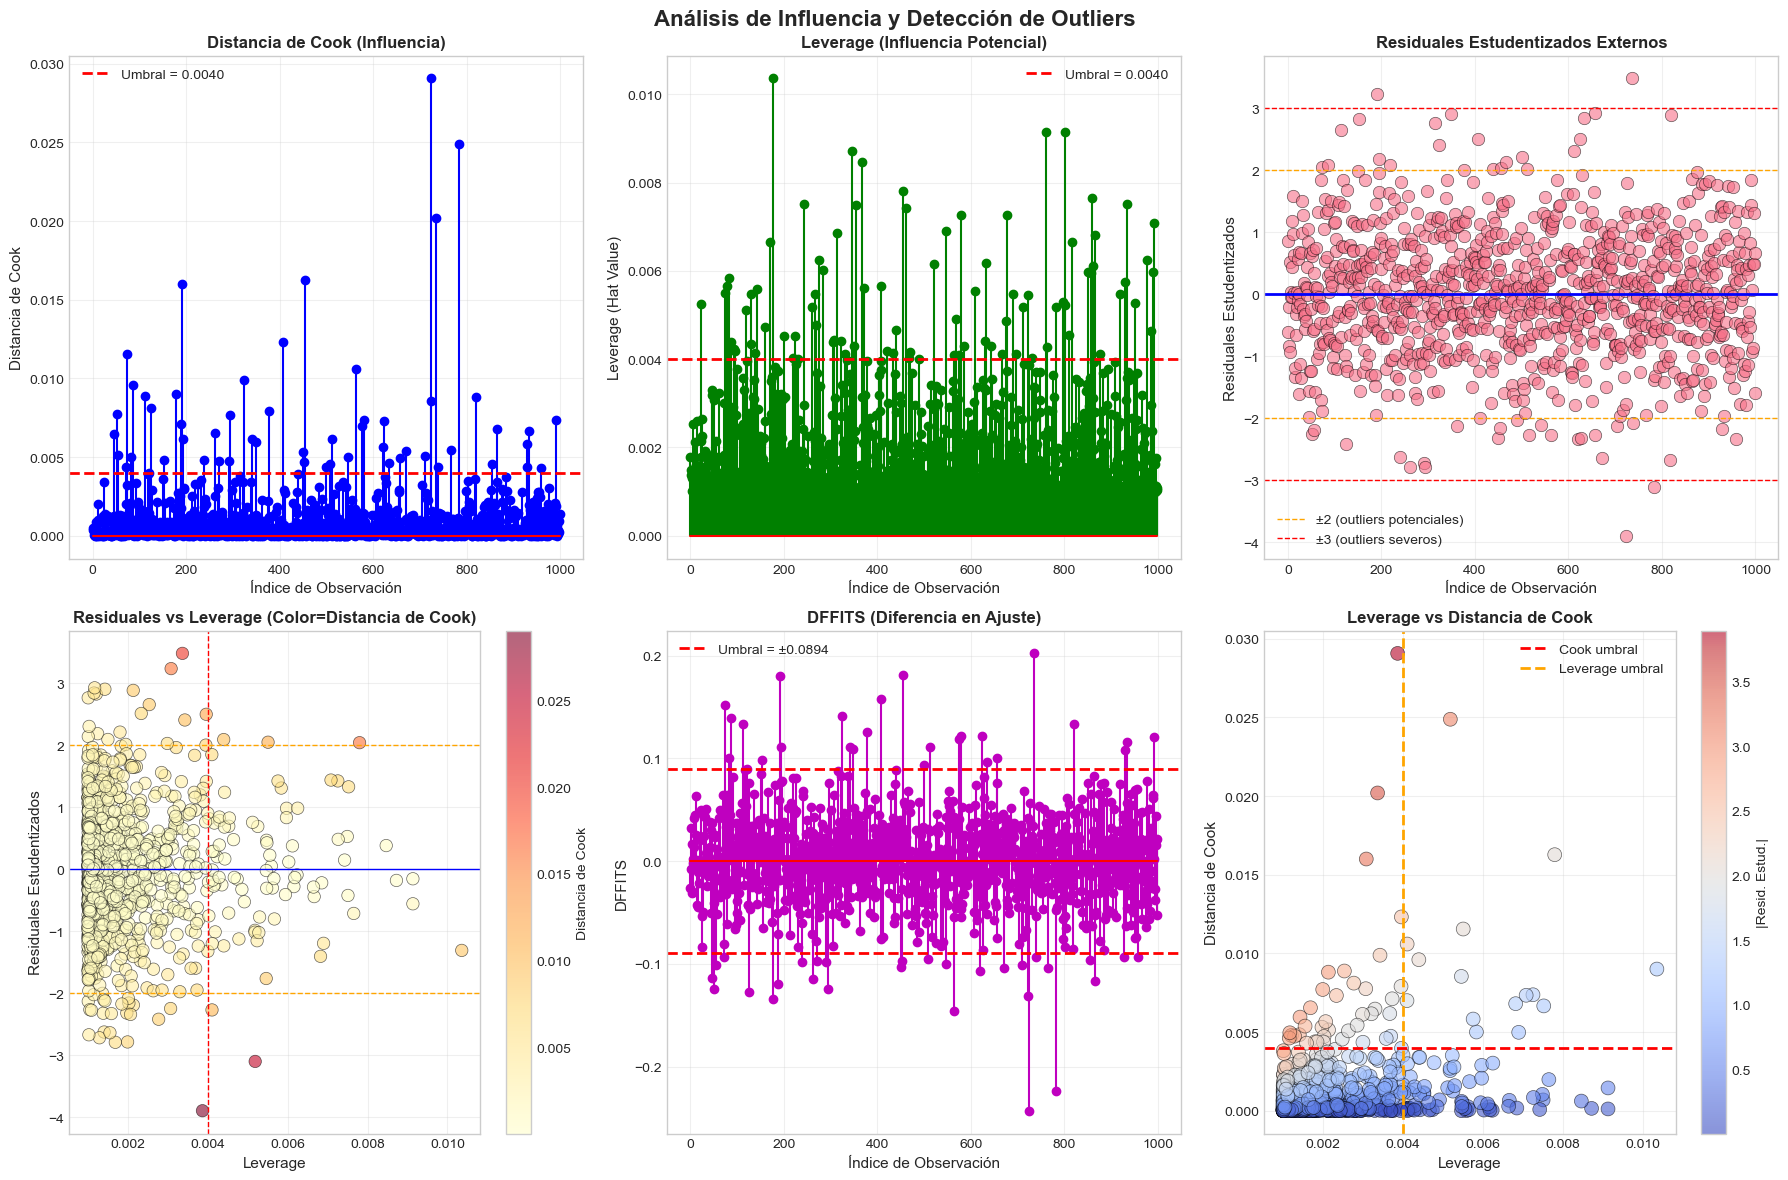


ANÁLISIS DE OBSERVACIONES INFLUYENTES

1. DISTANCIA DE COOK (Umbral = 0.0040)
   Observaciones influyentes: 54

   Índices de observaciones influyentes:
   - Obs 46: Weight=2858.7g, Fillet=1331.1g, Cook's D=0.0065
   - Obs 51: Weight=4759.0g, Fillet=2341.1g, Cook's D=0.0078
   - Obs 55: Weight=3148.4g, Fillet=1461.8g, Cook's D=0.0051
   - Obs 72: Weight=4743.2g, Fillet=2404.7g, Cook's D=0.0044
   - Obs 74: Weight=5199.6g, Fillet=3153.5g, Cook's D=0.0115
   - Obs 82: Weight=2419.5g, Fillet=1525.5g, Cook's D=0.0050
   - Obs 87: Weight=5019.5g, Fillet=3060.2g, Cook's D=0.0096
   - Obs 113: Weight=4630.5g, Fillet=2920.8g, Cook's D=0.0089
   - Obs 125: Weight=4689.6g, Fillet=2280.0g, Cook's D=0.0081
   - Obs 153: Weight=4127.6g, Fillet=2666.7g, Cook's D=0.0048

2. LEVERAGE (Umbral = 0.0040)
   Observaciones con alto leverage: 84

   Índices con alto leverage (valores extremos en X):
   - Obs 23: Weight=5160.1g, Leverage=0.0053
   - Obs 74: Weight=5199.6g, Leverage=0.0055
   - Obs 78: Weigh

In [10]:
# Calcular medidas de influencia
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(modelo)

# Distancia de Cook
cooks_d = influence.cooks_distance[0]
# Leverage (Hat values)
leverage = influence.hat_matrix_diag
# DFFITS
dffits = influence.dffits[0]
# Residuales estudentizados
student_resid = influence.resid_studentized_external

# Umbral para distancia de Cook (4/n)
cook_threshold = 4 / len(trucha)
# Umbral para leverage (2p/n o 3p/n)
p = modelo.model.exog.shape[1]  # número de parámetros
leverage_threshold = 2 * p / len(trucha)

# Gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Influencia y Detección de Outliers', fontsize=16, fontweight='bold')

# 1. Distancia de Cook
axes[0, 0].stem(range(len(cooks_d)), cooks_d, linefmt='b-', markerfmt='bo', basefmt='r-')
axes[0, 0].axhline(y=cook_threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral = {cook_threshold:.4f}')
axes[0, 0].set_xlabel('Índice de Observación', fontsize=11)
axes[0, 0].set_ylabel("Distancia de Cook", fontsize=11)
axes[0, 0].set_title("Distancia de Cook (Influencia)", fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Leverage
axes[0, 1].stem(range(len(leverage)), leverage, linefmt='g-', markerfmt='go', basefmt='r-')
axes[0, 1].axhline(y=leverage_threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral = {leverage_threshold:.4f}')
axes[0, 1].set_xlabel('Índice de Observación', fontsize=11)
axes[0, 1].set_ylabel('Leverage (Hat Value)', fontsize=11)
axes[0, 1].set_title('Leverage (Influencia Potencial)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuales estudentizados
axes[0, 2].scatter(range(len(student_resid)), student_resid, alpha=0.6, s=80, edgecolors='black', linewidths=0.5)
axes[0, 2].axhline(y=0, color='blue', linestyle='-', linewidth=2)
axes[0, 2].axhline(y=2, color='orange', linestyle='--', linewidth=1, label='±2 (outliers potenciales)')
axes[0, 2].axhline(y=-2, color='orange', linestyle='--', linewidth=1)
axes[0, 2].axhline(y=3, color='red', linestyle='--', linewidth=1, label='±3 (outliers severos)')
axes[0, 2].axhline(y=-3, color='red', linestyle='--', linewidth=1)
axes[0, 2].set_xlabel('Índice de Observación', fontsize=11)
axes[0, 2].set_ylabel('Residuales Estudentizados', fontsize=11)
axes[0, 2].set_title('Residuales Estudentizados Externos', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuales estudentizados vs Leverage
axes[1, 0].scatter(leverage, student_resid, alpha=0.6, s=80, c=cooks_d, cmap='YlOrRd', 
                   edgecolors='black', linewidths=0.5)
axes[1, 0].axhline(y=0, color='blue', linestyle='-', linewidth=1)
axes[1, 0].axhline(y=2, color='orange', linestyle='--', linewidth=1)
axes[1, 0].axhline(y=-2, color='orange', linestyle='--', linewidth=1)
axes[1, 0].axvline(x=leverage_threshold, color='red', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Leverage', fontsize=11)
axes[1, 0].set_ylabel('Residuales Estudentizados', fontsize=11)
axes[1, 0].set_title('Residuales vs Leverage (Color=Distancia de Cook)', fontsize=12, fontweight='bold')
plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label="Distancia de Cook")
axes[1, 0].grid(True, alpha=0.3)

# 5. DFFITS
axes[1, 1].stem(range(len(dffits)), dffits, linefmt='m-', markerfmt='mo', basefmt='r-')
dffits_threshold = 2 * np.sqrt(p / len(trucha))
axes[1, 1].axhline(y=dffits_threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral = ±{dffits_threshold:.4f}')
axes[1, 1].axhline(y=-dffits_threshold, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Índice de Observación', fontsize=11)
axes[1, 1].set_ylabel('DFFITS', fontsize=11)
axes[1, 1].set_title('DFFITS (Diferencia en Ajuste)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Gráfico de influencia (Leverage vs Cook)
axes[1, 2].scatter(leverage, cooks_d, alpha=0.6, s=100, c=np.abs(student_resid), cmap='coolwarm',
                   edgecolors='black', linewidths=0.5)
axes[1, 2].axhline(y=cook_threshold, color='red', linestyle='--', linewidth=2, label=f'Cook umbral')
axes[1, 2].axvline(x=leverage_threshold, color='orange', linestyle='--', linewidth=2, label=f'Leverage umbral')
axes[1, 2].set_xlabel('Leverage', fontsize=11)
axes[1, 2].set_ylabel('Distancia de Cook', fontsize=11)
axes[1, 2].set_title('Leverage vs Distancia de Cook', fontsize=12, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2], label='|Resid. Estud.|')

plt.tight_layout()
plt.show()

# Identificar observaciones influyentes
print("\n" + "="*70)
print("ANÁLISIS DE OBSERVACIONES INFLUYENTES")
print("="*70)

# Distancia de Cook
influential_cook = np.where(cooks_d > cook_threshold)[0]
print(f"\n1. DISTANCIA DE COOK (Umbral = {cook_threshold:.4f})")
print(f"   Observaciones influyentes: {len(influential_cook)}")
if len(influential_cook) > 0:
    print("\n   Índices de observaciones influyentes:")
    for idx in influential_cook[:10]:  # Mostrar máximo 10
        print(f"   - Obs {idx}: Weight={trucha.iloc[idx]['weight']:.1f}g, Fillet={trucha.iloc[idx]['fillet']:.1f}g, Cook's D={cooks_d[idx]:.4f}")

# Leverage
influential_leverage = np.where(leverage > leverage_threshold)[0]
print(f"\n2. LEVERAGE (Umbral = {leverage_threshold:.4f})")
print(f"   Observaciones con alto leverage: {len(influential_leverage)}")
if len(influential_leverage) > 0:
    print("\n   Índices con alto leverage (valores extremos en X):")
    for idx in influential_leverage[:10]:
        print(f"   - Obs {idx}: Weight={trucha.iloc[idx]['weight']:.1f}g, Leverage={leverage[idx]:.4f}")

# Outliers (residuales estudentizados)
outliers = np.where(np.abs(student_resid) > 2)[0]
severe_outliers = np.where(np.abs(student_resid) > 3)[0]
print(f"\n3. OUTLIERS (Residuales Estudentizados)")
print(f"   Outliers potenciales (|t| > 2): {len(outliers)}")
print(f"   Outliers severos (|t| > 3): {len(severe_outliers)}")
if len(severe_outliers) > 0:
    print("\n   Outliers severos:")
    for idx in severe_outliers:
        print(f"   - Obs {idx}: Weight={trucha.iloc[idx]['weight']:.1f}g, Fillet={trucha.iloc[idx]['fillet']:.1f}g")
        print(f"     Predicho={trucha.iloc[idx]['fillet_pred']:.1f}g, Residual={trucha.iloc[idx]['residuales']:.1f}g, t={student_resid[idx]:.2f}")

# DFFITS
influential_dffits = np.where(np.abs(dffits) > dffits_threshold)[0]
print(f"\n4. DFFITS (Umbral = ±{dffits_threshold:.4f})")
print(f"   Observaciones influyentes: {len(influential_dffits)}")

print("\n" + "="*70)
print("INTERPRETACIÓN")
print("="*70)
print("\n• Distancia de Cook: Mide cambio en todos los valores ajustados si se elimina la observación.")
print("  Valores > 4/n (o >1) son influyentes y merecen revisión.")
print("\n• Leverage: Mide qué tan extremo es el valor del predictor (X).")
print("  Alto leverage no es malo por sí solo, pero combinado con alto residual es problemático.")
print("\n• Residuales Estudentizados: Detectan outliers en Y.")
print("  |t| > 2: Outlier potencial. |t| > 3: Outlier severo.")
print("\n• DFFITS: Cambio en el valor ajustado de esa observación al eliminarla.")
print("  Combina información de leverage y residual.")

print("\n" + "="*70)
print("RECOMENDACIONES")
print("="*70)
print("\n• Investigar observaciones influyentes: ¿Errores de medición? ¿Condiciones especiales?")
print("• No eliminar automáticamente: Pueden ser datos válidos pero atípicos.")
print("• Comparar modelo con y sin outliers influyentes.")
print("• Considerar regresión robusta si hay muchos outliers.")
print("• En contexto industrial: Verificar calibración de instrumentos, proceso de fileteado.")

## 6. Métricas de Rendimiento del Modelo


MÉTRICAS DE RENDIMIENTO DEL MODELO

=== MÉTRICAS EN CONJUNTO DE ENTRENAMIENTO ===

R² (Coeficiente de Determinación): 0.8761
  Interpretación: El modelo explica el 87.61% de la variabilidad en peso de filete.

R² Ajustado: 0.8760
  (Penaliza la complejidad del modelo)

MAE (Error Absoluto Medio): 104.43 g
  Interpretación: En promedio, las predicciones se desvían 104.43g del valor real.
  Como % del promedio: 4.90%

RMSE (Raíz del Error Cuadrático Medio): 133.09 g
  Interpretación: Desviación estándar de los errores de predicción.
  Penaliza más los errores grandes que MAE.

MAPE (Error Porcentual Absoluto Medio): 4.96%
  Interpretación: Error promedio como porcentaje del valor real.
  Excelente (<5%=excelente, 5-10%=bueno, 10-15%=aceptable)

=== VALIDACIÓN CRUZADA (10-Fold) ===

R² promedio: 0.8724 ± 0.0212
  Rango: [0.8430, 0.9091]

MAE promedio: 104.66 ± 7.65 g
  Rango: [89.10, 117.84] g

RMSE promedio: 133.12 ± 8.24 g
  Rango: [113.78, 147.07] g

=== COMPARACIÓN CON MODELO NULO (M

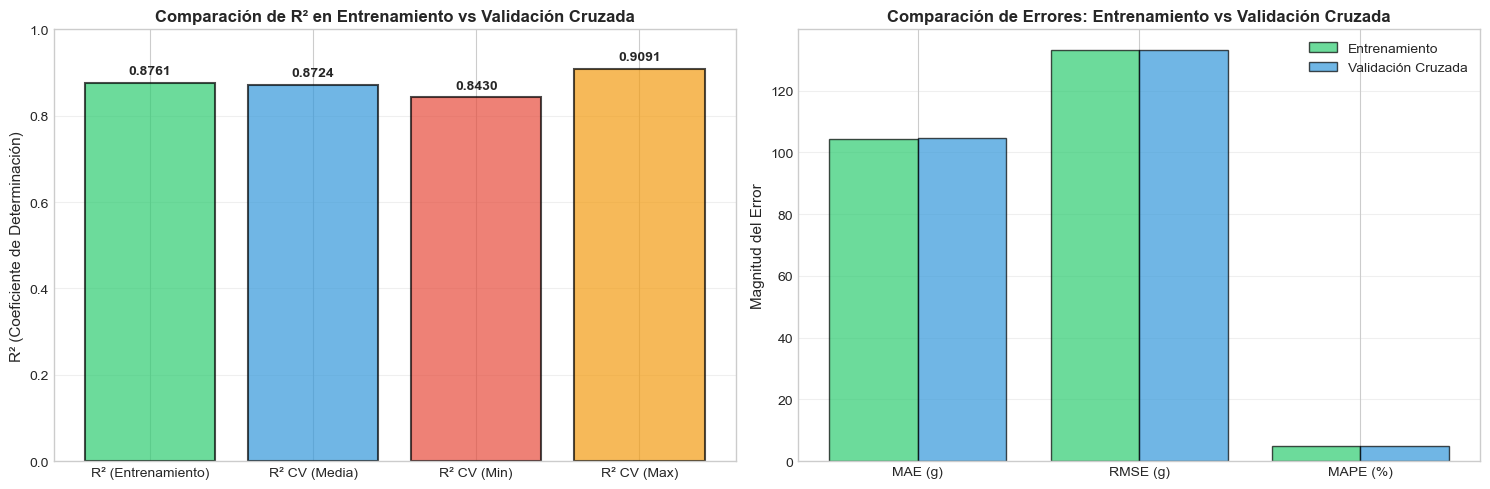


INTERPRETACIÓN

• Si R² entrenamiento ≈ R² CV: Modelo generaliza bien (no sobreajuste).
• Si R² entrenamiento >> R² CV: Posible sobreajuste.

• Diferencia R² (entr - CV): 0.38% → Generaliza bien

• MAE y RMSE en misma escala que la variable respuesta (g).
  Facilita interpretación práctica del error de predicción.

• MAPE es escala-independiente, útil para comparar modelos en diferentes datasets.


In [11]:
# Métricas de error
mae = mean_absolute_error(trucha['fillet'], trucha['fillet_pred'])
mse = mean_squared_error(trucha['fillet'], trucha['fillet_pred'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((trucha['fillet'] - trucha['fillet_pred']) / trucha['fillet'])) * 100

# Validación cruzada
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
lr = LinearRegression()
cv_r2 = cross_val_score(lr, trucha[['weight']], trucha['fillet'], cv=kf, scoring='r2')
cv_mae = -cross_val_score(lr, trucha[['weight']], trucha['fillet'], cv=kf, scoring='neg_mean_absolute_error')
cv_rmse = np.sqrt(-cross_val_score(lr, trucha[['weight']], trucha['fillet'], cv=kf, scoring='neg_mean_squared_error'))

print("\n" + "="*70)
print("MÉTRICAS DE RENDIMIENTO DEL MODELO")
print("="*70)

print("\n=== MÉTRICAS EN CONJUNTO DE ENTRENAMIENTO ===")
print(f"\nR² (Coeficiente de Determinación): {r_cuadrado:.4f}")
print(f"  Interpretación: El modelo explica el {r_cuadrado*100:.2f}% de la variabilidad en peso de filete.")

print(f"\nR² Ajustado: {r_cuadrado_adj:.4f}")
print(f"  (Penaliza la complejidad del modelo)")

print(f"\nMAE (Error Absoluto Medio): {mae:.2f} g")
print(f"  Interpretación: En promedio, las predicciones se desvían {mae:.2f}g del valor real.")
print(f"  Como % del promedio: {(mae/trucha['fillet'].mean())*100:.2f}%")

print(f"\nRMSE (Raíz del Error Cuadrático Medio): {rmse:.2f} g")
print(f"  Interpretación: Desviación estándar de los errores de predicción.")
print(f"  Penaliza más los errores grandes que MAE.")

print(f"\nMAPE (Error Porcentual Absoluto Medio): {mape:.2f}%")
print(f"  Interpretación: Error promedio como porcentaje del valor real.")
print(f"  {'Excelente' if mape < 5 else 'Bueno' if mape < 10 else 'Aceptable' if mape < 15 else 'Revisar'} (<5%=excelente, 5-10%=bueno, 10-15%=aceptable)")

print("\n=== VALIDACIÓN CRUZADA (10-Fold) ===")
print(f"\nR² promedio: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"  Rango: [{cv_r2.min():.4f}, {cv_r2.max():.4f}]")

print(f"\nMAE promedio: {cv_mae.mean():.2f} ± {cv_mae.std():.2f} g")
print(f"  Rango: [{cv_mae.min():.2f}, {cv_mae.max():.2f}] g")

print(f"\nRMSE promedio: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f} g")
print(f"  Rango: [{cv_rmse.min():.2f}, {cv_rmse.max():.2f}] g")

# Comparación con modelo nulo
media_fillet = trucha['fillet'].mean()
ss_total = np.sum((trucha['fillet'] - media_fillet)**2)
ss_residual = np.sum(trucha['residuales']**2)
mejora_vs_nulo = ((ss_total - ss_residual) / ss_total) * 100

print("\n=== COMPARACIÓN CON MODELO NULO (Media) ===")
print(f"\nModelo Nulo (predicción = media = {media_fillet:.2f}g):")
print(f"  MAE: {np.mean(np.abs(trucha['fillet'] - media_fillet)):.2f} g")
print(f"  RMSE: {np.sqrt(np.mean((trucha['fillet'] - media_fillet)**2)):.2f} g")

print(f"\nMejora del modelo vs modelo nulo: {mejora_vs_nulo:.2f}%")
print(f"  (Equivalente a R² × 100)")

# Gráfico de métricas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Comparación de R² y R² CV
axes[0].bar(['R² (Entrenamiento)', 'R² CV (Media)', 'R² CV (Min)', 'R² CV (Max)'],
            [r_cuadrado, cv_r2.mean(), cv_r2.min(), cv_r2.max()],
            color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'],
            alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² (Coeficiente de Determinación)', fontsize=11)
axes[0].set_title('Comparación de R² en Entrenamiento vs Validación Cruzada', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([r_cuadrado, cv_r2.mean(), cv_r2.min(), cv_r2.max()]):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Comparación de errores
x_pos = np.arange(3)
entrenamiento = [mae, rmse, mape]
cv_media = [cv_mae.mean(), cv_rmse.mean(), mape]  # MAPE no disponible en CV directamente
axes[1].bar(x_pos - 0.2, entrenamiento, 0.4, label='Entrenamiento', color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].bar(x_pos + 0.2, cv_media, 0.4, label='Validación Cruzada', color='#3498db', alpha=0.7, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['MAE (g)', 'RMSE (g)', 'MAPE (%)'])
axes[1].set_ylabel('Magnitud del Error', fontsize=11)
axes[1].set_title('Comparación de Errores: Entrenamiento vs Validación Cruzada', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETACIÓN")
print("="*70)
print("\n• Si R² entrenamiento ≈ R² CV: Modelo generaliza bien (no sobreajuste).")
print("• Si R² entrenamiento >> R² CV: Posible sobreajuste.")
print(f"\n• Diferencia R² (entr - CV): {(r_cuadrado - cv_r2.mean())*100:.2f}% → {'Generaliza bien' if abs(r_cuadrado - cv_r2.mean()) < 0.05 else 'Revisar'}")
print("\n• MAE y RMSE en misma escala que la variable respuesta (g).")
print("  Facilita interpretación práctica del error de predicción.")
print("\n• MAPE es escala-independiente, útil para comparar modelos en diferentes datasets.")

## 7. Análisis de Correlación


ANÁLISIS DE CORRELACIÓN

=== CORRELACIÓN DE PEARSON (Lineal) ===
Coeficiente r: 0.936014
Valor p: 0.00e+00
R² (varianza compartida): 0.876122 (87.61%)

Interpretación: Correlación muy fuerte positiva.
✓ Altamente significativa (p < 0.001)

=== CORRELACIÓN DE SPEARMAN (Monotónica) ===
Coeficiente ρ (rho): 0.932288
Valor p: 0.00e+00

Interpretación: Mide relación monotónica (no necesariamente lineal).
  Útil cuando hay outliers o relación no lineal.
✓ Altamente significativa (p < 0.001)

=== COMPARACIÓN ===
Diferencia |r - ρ|: 0.003726
  → Las correlaciones son muy similares: relación lineal robusta.

Intervalo de confianza 95% para r: [0.927861, 0.943272]

=== MATRIZ DE CORRELACIONES ===
                   weight  fillet  porcentaje_filete
weight             1.0000  0.9360            -0.0299
fillet             0.9360  1.0000             0.3189
porcentaje_filete -0.0299  0.3189             1.0000


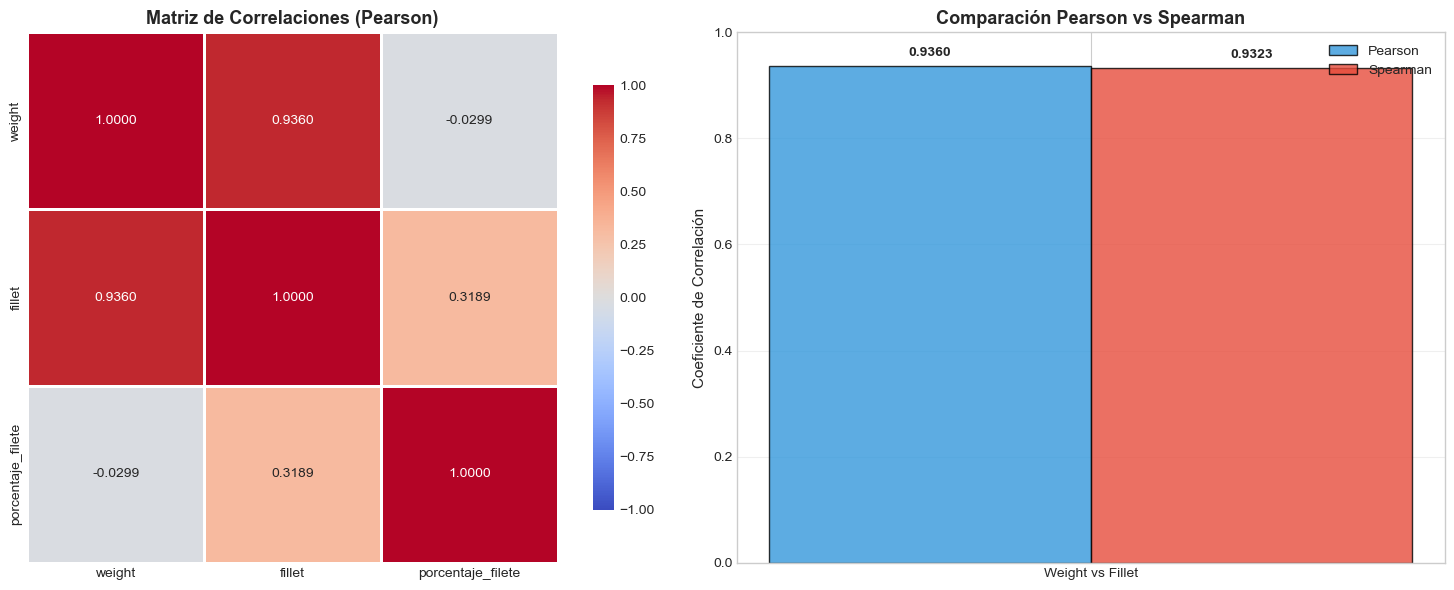


IMPLICACIONES PRÁCTICAS

• Una correlación r=0.9360 indica que:
  - Conocer el peso corporal permite predecir el 87.6% de la variabilidad en filete.
  - El 12.4% restante se debe a otros factores:
    · Variabilidad individual (condición corporal, contenido graso)
    · Técnica y habilidad del operador de fileteado
    · Características anatómicas (tamaño de cabeza, vísceras)
    · Calidad del pez (salud, alimentación)

• La alta correlación positiva confirma:
  - Peces más grandes producen filetes más pesados (esperable).
  - El modelo de regresión lineal es apropiado para este dataset.
  - El peso corporal es un predictor efectivo del peso de filete.


In [12]:
# Correlaciones
r_pearson, p_pearson = pearsonr(trucha['weight'], trucha['fillet'])
r_spearman, p_spearman = spearmanr(trucha['weight'], trucha['fillet'])

print("\n" + "="*70)
print("ANÁLISIS DE CORRELACIÓN")
print("="*70)

print("\n=== CORRELACIÓN DE PEARSON (Lineal) ===")
print(f"Coeficiente r: {r_pearson:.6f}")
print(f"Valor p: {p_pearson:.2e}")
print(f"R² (varianza compartida): {r_pearson**2:.6f} ({r_pearson**2*100:.2f}%)")

# Interpretación de magnitud
if abs(r_pearson) < 0.3:
    magnitud = "débil"
elif abs(r_pearson) < 0.7:
    magnitud = "moderada"
elif abs(r_pearson) < 0.9:
    magnitud = "fuerte"
else:
    magnitud = "muy fuerte"

print(f"\nInterpretación: Correlación {magnitud} {'positiva' if r_pearson > 0 else 'negativa'}.")
if p_pearson < 0.001:
    print(f"✓ Altamente significativa (p < 0.001)")
elif p_pearson < 0.05:
    print(f"✓ Significativa (p < 0.05)")
else:
    print(f"✗ No significativa (p ≥ 0.05)")

print("\n=== CORRELACIÓN DE SPEARMAN (Monotónica) ===")
print(f"Coeficiente ρ (rho): {r_spearman:.6f}")
print(f"Valor p: {p_spearman:.2e}")

print("\nInterpretación: Mide relación monotónica (no necesariamente lineal).")
print("  Útil cuando hay outliers o relación no lineal.")
if p_spearman < 0.001:
    print(f"✓ Altamente significativa (p < 0.001)")
elif p_spearman < 0.05:
    print(f"✓ Significativa (p < 0.05)")
else:
    print(f"✗ No significativa (p ≥ 0.05)")

# Comparación
print("\n=== COMPARACIÓN ===")
dif_correlaciones = abs(r_pearson - r_spearman)
print(f"Diferencia |r - ρ|: {dif_correlaciones:.6f}")
if dif_correlaciones < 0.05:
    print("  → Las correlaciones son muy similares: relación lineal robusta.")
elif dif_correlaciones < 0.15:
    print("  → Diferencia moderada: revisar linealidad y outliers.")
else:
    print("  → Diferencia notable: relación puede no ser lineal o hay outliers influyentes.")

# Intervalo de confianza para r de Pearson
# Transformación de Fisher Z
z = np.arctanh(r_pearson)
se = 1 / np.sqrt(len(trucha) - 3)
z_critical = 1.96  # 95% CI
ci_lower_z = z - z_critical * se
ci_upper_z = z + z_critical * se
ci_lower_r = np.tanh(ci_lower_z)
ci_upper_r = np.tanh(ci_upper_z)

print(f"\nIntervalo de confianza 95% para r: [{ci_lower_r:.6f}, {ci_upper_r:.6f}]")

# Matriz de correlación extendida
corr_matrix = trucha[['weight', 'fillet', 'porcentaje_filete']].corr()

print("\n=== MATRIZ DE CORRELACIONES ===")
print(corr_matrix.round(4))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Heatmap de correlaciones
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='coolwarm', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Matriz de Correlaciones (Pearson)', fontsize=13, fontweight='bold')

# 2. Comparación Pearson vs Spearman
categorias = ['Weight vs Fillet']
x_pos = np.arange(len(categorias))
axes[1].bar(x_pos - 0.2, [r_pearson], 0.4, label='Pearson', color='#3498db', alpha=0.8, edgecolor='black')
axes[1].bar(x_pos + 0.2, [r_spearman], 0.4, label='Spearman', color='#e74c3c', alpha=0.8, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(categorias)
axes[1].set_ylabel('Coeficiente de Correlación', fontsize=11)
axes[1].set_title('Comparación Pearson vs Spearman', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
for i, (p, s) in enumerate(zip([r_pearson], [r_spearman])):
    axes[1].text(i - 0.2, p + 0.02, f'{p:.4f}', ha='center', fontweight='bold')
    axes[1].text(i + 0.2, s + 0.02, f'{s:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("IMPLICACIONES PRÁCTICAS")
print("="*70)
print(f"\n• Una correlación r={r_pearson:.4f} indica que:")
print(f"  - Conocer el peso corporal permite predecir el {r_pearson**2*100:.1f}% de la variabilidad en filete.")
print(f"  - El {(1-r_pearson**2)*100:.1f}% restante se debe a otros factores:")
print("    · Variabilidad individual (condición corporal, contenido graso)")
print("    · Técnica y habilidad del operador de fileteado")
print("    · Características anatómicas (tamaño de cabeza, vísceras)")
print("    · Calidad del pez (salud, alimentación)")

print("\n• La alta correlación positiva confirma:")
print("  - Peces más grandes producen filetes más pesados (esperable).")
print("  - El modelo de regresión lineal es apropiado para este dataset.")
print("  - El peso corporal es un predictor efectivo del peso de filete.")

## 8. Conclusiones y Recomendaciones para la Industria

In [13]:
print("\n" + "="*80)
print("INFORME EJECUTIVO - ANÁLISIS PESO CORPORAL VS PESO DE FILETE EN TRUCHA")
print("="*80)

print("\n1. RESUMEN DEL MODELO")
print(f"   Ecuación: Filete (g) = {intercepto:.4f} + {pendiente:.6f} × Peso (g)")
print(f"   R² = {r_cuadrado:.4f} ({r_cuadrado*100:.2f}% de varianza explicada)")
print(f"   Correlación (r) = {r_pearson:.4f} (p < 0.001)")
print(f"   Error promedio (MAE) = {mae:.2f} g ({(mae/trucha['fillet'].mean())*100:.2f}% del promedio)")
print(f"   MAPE = {mape:.2f}%")

print("\n2. RENDIMIENTO DE FILETE")
print(f"   Rendimiento promedio: {trucha['porcentaje_filete'].mean():.2f}% ± {trucha['porcentaje_filete'].std():.2f}%")
print(f"   Rango observado: {trucha['porcentaje_filete'].min():.2f}% - {trucha['porcentaje_filete'].max():.2f}%")
print(f"   Coeficiente de variación: {(trucha['porcentaje_filete'].std()/trucha['porcentaje_filete'].mean())*100:.2f}%")

print("\n3. VALIDACIÓN DE SUPUESTOS")
print(f"   ✓ Linealidad: Relación lineal fuerte (r={r_pearson:.4f})")
print(f"   ✓ Independencia: DW={dw_stat:.3f} {'[OK]' if 1.5 <= dw_stat <= 2.5 else '[REVISAR]'}")
print(f"   ✓ Homocedasticidad: Breusch-Pagan p={bp_lm_p:.4f} {'[OK]' if bp_lm_p > 0.05 else '[NO CUMPLE]'}")
print(f"   ✓ Normalidad: Shapiro p={shapiro_p:.4f} {'[OK]' if shapiro_p > 0.05 else '[NO CUMPLE]'}")

conclusion_supuestos = "APROBADO" if (1.5 <= dw_stat <= 2.5 and bp_lm_p > 0.05 and shapiro_p > 0.05) else "REVISAR"
print(f"\n   CONCLUSIÓN: Supuestos {conclusion_supuestos}. ", end="")
if conclusion_supuestos == "APROBADO":
    print("El modelo de regresión es VÁLIDO y confiable.")
else:
    print("Revisar supuestos no cumplidos antes de aplicar.")

print("\n4. OBSERVACIONES INFLUYENTES")
print(f"   Observaciones con alta influencia (Cook): {len(influential_cook)}")
print(f"   Outliers severos (|t| > 3): {len(severe_outliers)}")
if len(influential_cook) > 0 or len(severe_outliers) > 0:
    print("   ⚠ ACCIÓN: Revisar estas observaciones para detectar errores de medición o")
    print("     condiciones especiales de procesamiento.")
else:
    print("   ✓ No se detectaron outliers problemáticos.")

print("\n5. APLICACIONES PRÁCTICAS")
print("\n   A. PREDICCIÓN DE RENDIMIENTO:")
print("      Usar el modelo para estimar peso de filete antes del procesamiento.")
print("      Permite:")
print("      • Planificación de producción y logística")
print("      • Estimación de ingresos por lote")
print("      • Optimización de clasificación por tamaño")

print("\n   B. CLASIFICACIÓN ÓPTIMA:")
pesos_clase = [3000, 3500, 4000, 4500, 5000]
print("      Ejemplos de predicción por categoría de peso:")
for peso in pesos_clase:
    filete_pred = intercepto + pendiente * peso
    rendimiento_pred = (filete_pred / peso) * 100
    precio_kg = 8.5  # Ejemplo: USD/kg
    valor_filete = (filete_pred / 1000) * precio_kg
    print(f"      • Peso {peso}g → Filete {filete_pred:.0f}g ({rendimiento_pred:.1f}%) → Valor aprox. ${valor_filete:.2f}")

print("\n   C. CONTROL DE CALIDAD:")
print("      • Monitorear desviaciones del modelo para detectar problemas:")
print("        - Cambios en técnica de fileteado")
print("        - Variación en calidad del pescado")
print("        - Necesidad de capacitación del personal")
print(f"      • Alerta si el rendimiento < {trucha['porcentaje_filete'].mean() - 1.5*trucha['porcentaje_filete'].std():.1f}%")
print(f"        o > {trucha['porcentaje_filete'].mean() + 1.5*trucha['porcentaje_filete'].std():.1f}%")

print("\n   D. OPTIMIZACIÓN ECONÓMICA:")
print("      • Determinar peso óptimo de cosecha considerando:")
print("        - Rendimiento de filete")
print("        - Costos de alimentación y producción")
print("        - Precio de mercado por categoría de tamaño")
print("      • Modelo ayuda a cuantificar valor agregado del incremento de peso")

print("\n6. LIMITACIONES Y CONSIDERACIONES")
print("\n   • Modelo es específico para las condiciones actuales:")
print("     - Línea genética/cepa de trucha")
print("     - Técnica y equipamiento de fileteado")
print("     - Rango de pesos estudiado")
print("\n   • Factores no incluidos que pueden afectar rendimiento:")
print("     - Condición corporal (factor K)")
print("     - Contenido graso y estado nutricional")
print("     - Sexo y madurez sexual")
print("     - Temporada y temperatura del agua")
print("\n   • Revalidar el modelo periódicamente con nuevos datos")

print("\n7. RECOMENDACIONES ESTRATÉGICAS")
print("\n   CORTO PLAZO:")
print("   • Implementar sistema de predicción automática en planta")
print("   • Capacitar personal en interpretación de rendimientos esperados")
print("   • Establecer alertas para lotes con rendimiento anómalo")
print("\n   MEDIANO PLAZO:")
print("   • Expandir modelo incluyendo variables adicionales:")
print("     - Factor de condición (K = peso/longitud³)")
print("     - Sexo, edad, línea genética")
print("     - Parámetros de cultivo (temperatura, alimentación)")
print("   • Desarrollar modelos específicos por categoría de peso")
print("   • Integrar con sistema ERP para optimización económica")
print("\n   LARGO PLAZO:")
print("   • Implementar machine learning para predicción más precisa")
print("   • Optimización multi-objetivo: rendimiento, calidad, costos")
print("   • Trazabilidad completa: desde alevinaje hasta procesamiento")

print("\n8. CONCLUSIÓN GENERAL")
print(f"\n   El modelo de regresión lineal desarrollado es {'ROBUSTO Y CONFIABLE' if conclusion_supuestos == 'APROBADO' else 'REQUIERE AJUSTES'}.")
print(f"   Con R²={r_cuadrado:.4f} y error promedio de {mae:.0f}g ({mape:.1f}%),")
print("   constituye una herramienta valiosa para:")
print("   • Planificación operativa y logística")
print("   • Control de calidad de procesamiento")
print("   • Optimización económica de la producción")
print("\n   La implementación práctica del modelo permitirá mejorar")
print("   la eficiencia operacional y la toma de decisiones basada en datos.")

print("\n" + "="*80)
print("FIN DEL ANÁLISIS")
print("="*80)


INFORME EJECUTIVO - ANÁLISIS PESO CORPORAL VS PESO DE FILETE EN TRUCHA

1. RESUMEN DEL MODELO
   Ecuación: Filete (g) = 20.4835 + 0.550370 × Peso (g)
   R² = 0.8761 (87.61% de varianza explicada)
   Correlación (r) = 0.9360 (p < 0.001)
   Error promedio (MAE) = 104.43 g (4.90% del promedio)
   MAPE = 4.96%

2. RENDIMIENTO DE FILETE
   Rendimiento promedio: 55.59% ± 3.44%
   Rango observado: 45.00% - 65.00%
   Coeficiente de variación: 6.19%

3. VALIDACIÓN DE SUPUESTOS
   ✓ Linealidad: Relación lineal fuerte (r=0.9360)
   ✓ Independencia: DW=1.987 [OK]
   ✓ Homocedasticidad: Breusch-Pagan p=0.0000 [NO CUMPLE]
   ✓ Normalidad: Shapiro p=0.4381 [OK]

   CONCLUSIÓN: Supuestos REVISAR. Revisar supuestos no cumplidos antes de aplicar.

4. OBSERVACIONES INFLUYENTES
   Observaciones con alta influencia (Cook): 54
   Outliers severos (|t| > 3): 4
   ⚠ ACCIÓN: Revisar estas observaciones para detectar errores de medición o
     condiciones especiales de procesamiento.

5. APLICACIONES PRÁCTICAS